# Khan 2018 Mouse Lens Re-analysis

## Lens changes with age notebook
## Younger versus older lenses in a pairwise comparison
### TMM normalization is used after IRS here

### Prepared by Phil Wilmarth, PSR Core, OHSU

### December 12, 2023

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [Young versus old comparison](#Age)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

This is a three plex experiment using 10-plex TMT with no reference channels per plex. Each plex is a set of biological replicates of developing mouse lens: E15, E18, P0, P3, P6, P9 (six ages, 3 day intervals). Data were downloaded from PRIDE (PXD006381) and processed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (*Wilmarth 2009*) and IRS normalized using the average of each plex as a mock reference channel (*Plubell 2017*). This is the publication:

> Khan, S.Y., Ali, M., Kabir, F., Renuse, S., Na, C.H., Talbot, C.C., Hackett, S.F. and Riazuddin, S.A., 2018. Proteome profiling of developing murine lens through mass spectrometry. Investigative Ophthalmology & Visual Science, 59(1), pp.100-107.

#### Experimental Groups:

Age|Description|Biological Replicates|Pooled Mice Lenses
---|---|---|---
E15|Embryonic day 15|3|23 embryos
E18|Embryonic day 18|3|10 embryos
P0|Newborn|3|8 pups
P3|3-day old|3|8 pups
P6|6-day old|3|8 pups
P9|9-day old|3|8 pups

#### Sample Key:

Channel|Plex 1|Plex 2|Plex 3
---|---|---|---
126C|E15|E15|E15
127N|E18|E18|E18
127C|P0|P0|P0
128N|P3|P3|P3
128C|P6|P6|P6
129N|P9|P9|P9
129C|Mix?|Mix?|Mix?
130N|unused|unused|unused
130C|unused|unused|unused
131N|unused|unused|unused

### This notebook will compare lenses of different ages

There were three plexes with biological replicates of the 6 ages. There was no pooled internal reference standard. The plex average intensity for each protein was used as a mock reference intensity vector. IRS was used to put all three plexes (18 samples) on a common intensity scale. Statistical analysis is done with edgeR (*Robinson 2010A*) exact test after TMM normalization (*Robinson 2010B*)

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. bioinformatics, 26(1), pp.139-140.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), pp.1-9.

---

## Load the necessary R libraries

In [16]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

## Define common functions for notebook use

In [17]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE, table = TRUE, title = "TMM Normalized data") {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # color - color vector for boxplots
        # plot - flag to show boxplot or not
        # table - flag to print norm factor tables or not
        # title - main title for boxplots
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    if(table == TRUE) {
        cat("\nLibrary size factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    }
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    if(table == TRUE) {
        cat("\nTrimmed mean of M-values (TMM) factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    }
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    if(table == TRUE) {
        cat("\nCombined (lib size and TMM) normalization factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))
    }

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = title)
    }
    tmt_tmm
}

# ============ runs an edgeR exact pairwise test ========================
pairwise_test <- function(delist, pair, p.value) {
    # runs an edgeR exact test and returns results
    et <- exactTest(delist, pair = pair)
    tt <- topTags(et, n = Inf, sort.by = "none")
    
    # print top tags
    cat("\n")
    print(topTags(et)$table, digits = 4)
    cat("\n")
    
    # count candidates
    print(summary(decideTestsDGE(et, p.value = p.value)))

    # see candidates on an MA plot
    plotMD(et, p.value = p.value)
    abline(h = c(-1, 1), col = "black")
    
    # check the p-value distribution
    pval <- ggplot(tt$table, aes(PValue)) + 
      geom_histogram(bins = 100, fill = "white", color = "black") + 
      geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
      ggtitle("p-value distribution")
    print(pval) # this makes the plot show up
    
    tt # return top-tags object
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== log2_fold_changes ================================================
log2_fold_changes <- function(results, left, right, title) {
    # Makes log2 fold change plots by candidate
        # results - results data frame
        # left - lower FC log2 limit
        # right - upper FC log2 limit
        # title - plot title
    
    # see how many candidates by category
    cat("\n")
    print(results %>% count(candidate))
    cat("\n")

    # plot log2 fold-changes by category
    fc <- ggplot(results, aes(x = logFC, fill = candidate)) +
      geom_histogram(binwidth=0.1, color = "black") +
      facet_wrap(~candidate) +
      coord_cartesian(xlim = c(-left, right)) +
      ggtitle(title)
    print(fc)
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
#    identifier <- accession
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags, color = c("red", "blue")) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color_bars = c(rep(color[1], nleft), rep(color[2], nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color_bars, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

## <a name="load_data"></a>Read the IRS-normalized TMT intensity data

We checked the data quality in an earlier notebook, and it looked okay.

In [18]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", 
                        guess_max = 5854)

# "Filter" column flags contams and decoys
# "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the table from pandas is sorted so the rows we want come first
data_all <- filter(data_import, is.na(Filter), is.na(Missing))
data_sl <- select(data_all, contains("SLNorm_"))
data_irs <- select(data_all, contains("IRSNorm_"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows of data we have
length(accessions)

# set some larger plot dimensions
set_plot_dimensions(9, 9)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Description = col_character()
)

See spec(...) for full column specifications.



[1] 4249

### Organize the data frame by biological group

In [19]:
# define the groups (after IRS)
E15_irs <- select(data_irs, contains("_E15_"))
E18_irs <- select(data_irs, contains("_E18_"))
P0_irs <- select(data_irs, contains("_P0_"))
P3_irs <- select(data_irs, contains("_P3_"))
P6_irs <- select(data_irs, contains("_P6_"))
P9_irs <- select(data_irs, contains("_P9_"))

# put groups together into a single data frame
tmt_data <- bind_cols(E15_irs, E18_irs, P0_irs, P3_irs, P6_irs, P9_irs)

# Set color vector:
#   dark blue - E15
#   blue - E18
#   dark red - P0
#   red - P3
#   dark green - P6
#   green - P9
colors <- c(rep("blue", 6), rep("red", 6), rep("green", 6))

# make indexes for young and old
young <- 1:6
middle <- 7:12
old <- 13:18

## <a name="TMM"></a>Load data into edgeR data structures

We are defining the groups that will be compared explicitly and using all the samples for variance estimates. We put the data into a data frame, grouped by condition. We defined some column indexes for each condition, set some colors for plotting. We can run TMM normalization, check the final intensity distributions, and see how distinct the biological groups are in an MDS cluster view.


Library size factors:
 IRSNorm_E15_1 -> 1.031476
 IRSNorm_E15_2 -> 1.008094
 IRSNorm_E15_3 -> 0.986400
 IRSNorm_E18_1 -> 1.010526
 IRSNorm_E18_2 -> 1.012694
 IRSNorm_E18_3 -> 0.997802
 IRSNorm_P0_1 -> 0.998726
 IRSNorm_P0_2 -> 0.991580
 IRSNorm_P0_3 -> 0.999595
 IRSNorm_P3_1 -> 0.986234
 IRSNorm_P3_2 -> 0.999611
 IRSNorm_P3_3 -> 1.005907
 IRSNorm_P6_1 -> 0.980859
 IRSNorm_P6_2 -> 0.993474
 IRSNorm_P6_3 -> 1.011724
 IRSNorm_P9_1 -> 0.974078
 IRSNorm_P9_2 -> 1.004781
 IRSNorm_P9_3 -> 1.009580

Trimmed mean of M-values (TMM) factors:
 IRSNorm_E15_1 -> 0.712297
 IRSNorm_E15_2 -> 0.660870
 IRSNorm_E15_3 -> 0.666675
 IRSNorm_E18_1 -> 0.839775
 IRSNorm_E18_2 -> 0.704975
 IRSNorm_E18_3 -> 0.849973
 IRSNorm_P0_1 -> 0.908618
 IRSNorm_P0_2 -> 0.896906
 IRSNorm_P0_3 -> 0.880678
 IRSNorm_P3_1 -> 1.077557
 IRSNorm_P3_2 -> 1.213998
 IRSNorm_P3_3 -> 1.069485
 IRSNorm_P6_1 -> 1.224558
 IRSNorm_P6_2 -> 1.314099
 IRSNorm_P6_3 -> 1.317240
 IRSNorm_P9_1 -> 1.463104
 IRSNorm_P9_2 -> 1.354746
 IRSNorm_P9_3 

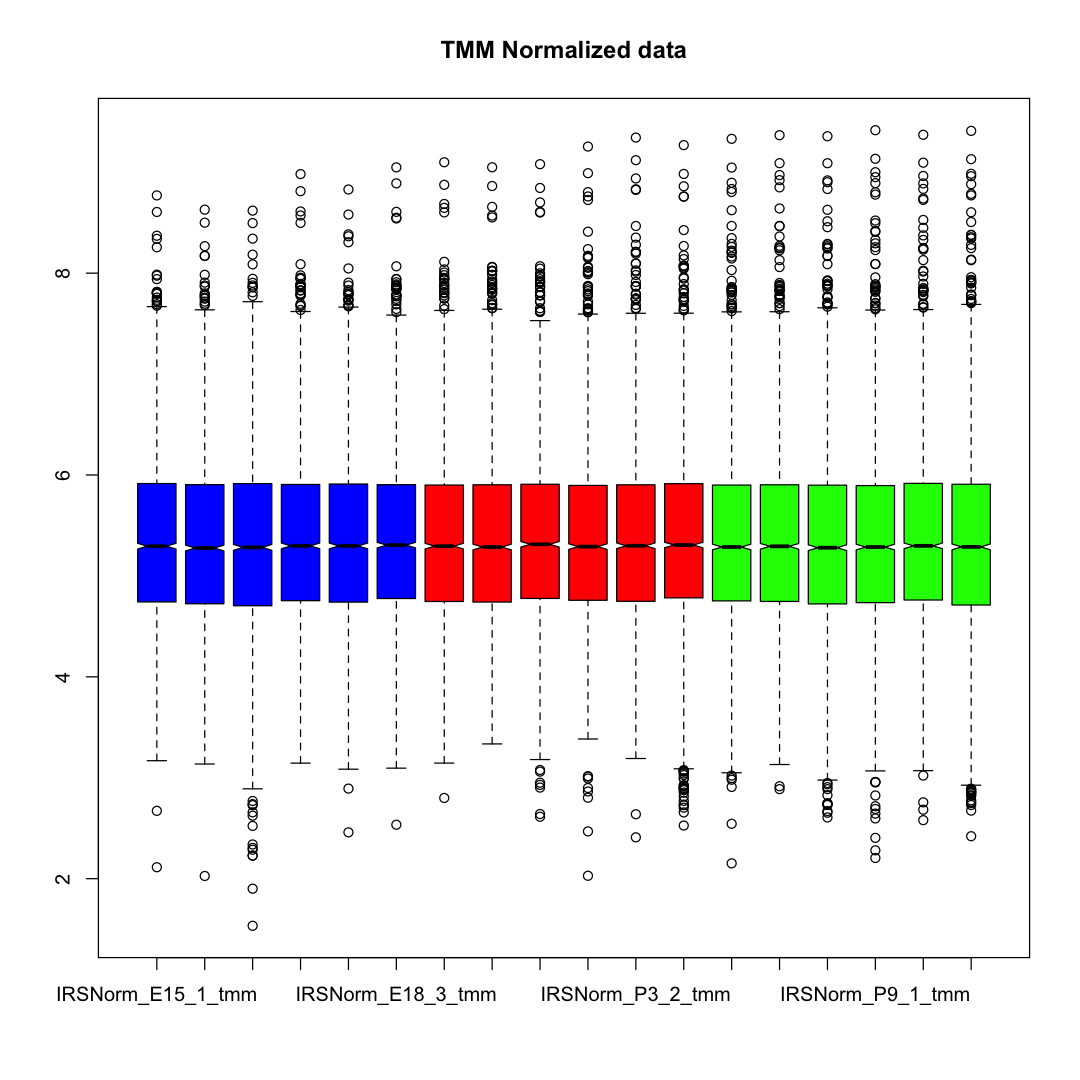

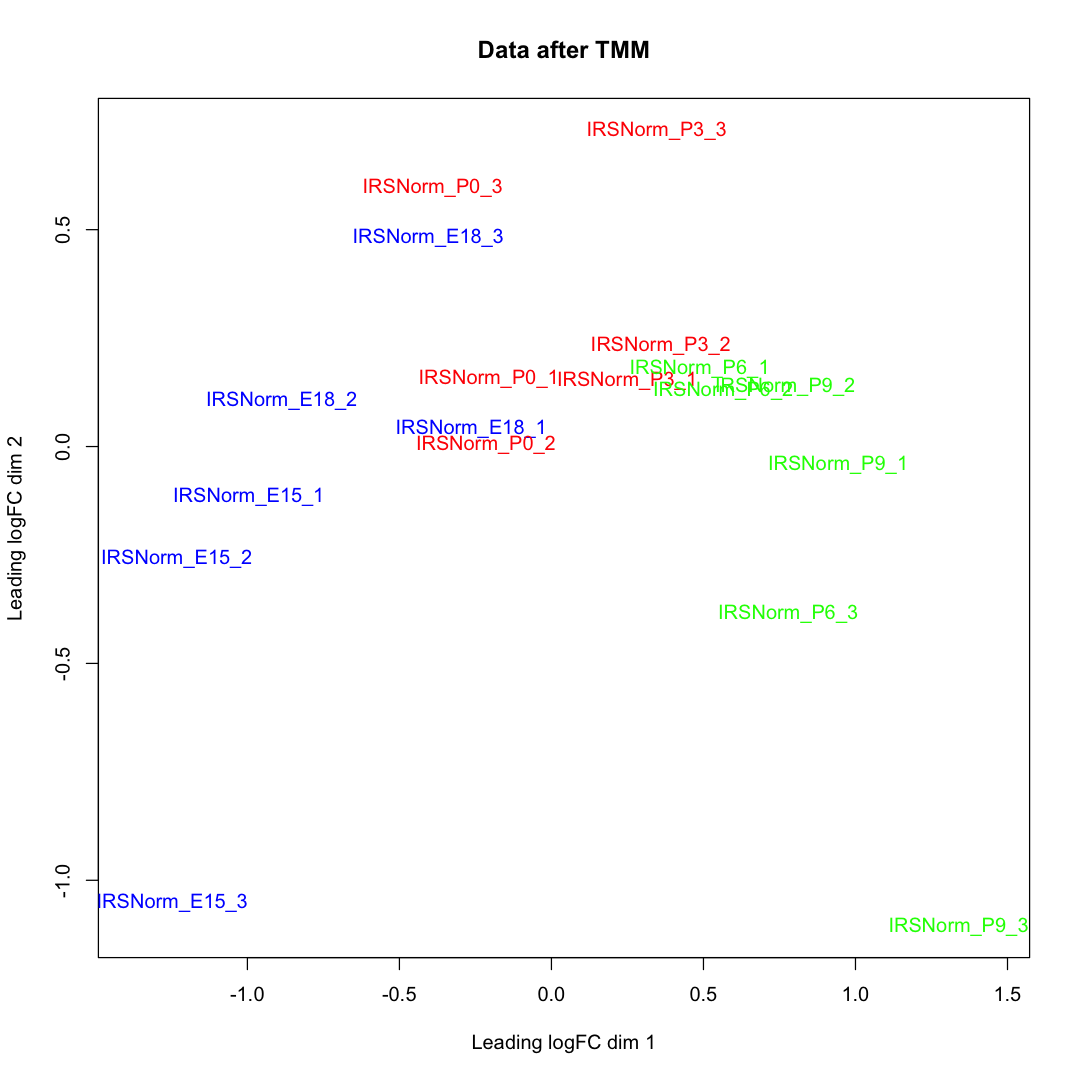

In [20]:
# get the biological sample data into a DGEList object
group <- c(rep('young', 6), rep('middle', 6), rep('old', 6))
y <- DGEList(counts = tmt_data, group = group, genes = accessions)

# run TMM normalization so we have the results in y
y <- calcNormFactors(y)

tmt_tmm <- apply_tmm_factors(y, table = TRUE, color = colors)

# check the clustering
plotMDS(y, col = colors, main = "Data after TMM")

### Groups separate left-to-right

The TMM factors range from 0.7 to 1.5 suggesting some large compositional changes across the developmental ages. This testing is mostly a categorization exercise. We are lumping E15 and E18 together to get a "young" age and lumping the P6 and P9 together to get an "old" age. The pairwise comparison will have three categories: proteins that went up, proteins that did not go up or down, and proteins that went down with age. This may help up interpret the ANOVA results.

## EdgeR statistical testing starts here

### Compute the shared variance trend

One of the more powerful features of edgeR is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 18 samples across all ages to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR `estimateDisp` function that does all of this and a visualization function to check the result.

We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take specified conditions and compare them using the normalization factors and dispersion estimates saved in the DGEList object `y`.

Design matrix not provided. Switch to the classic mode.


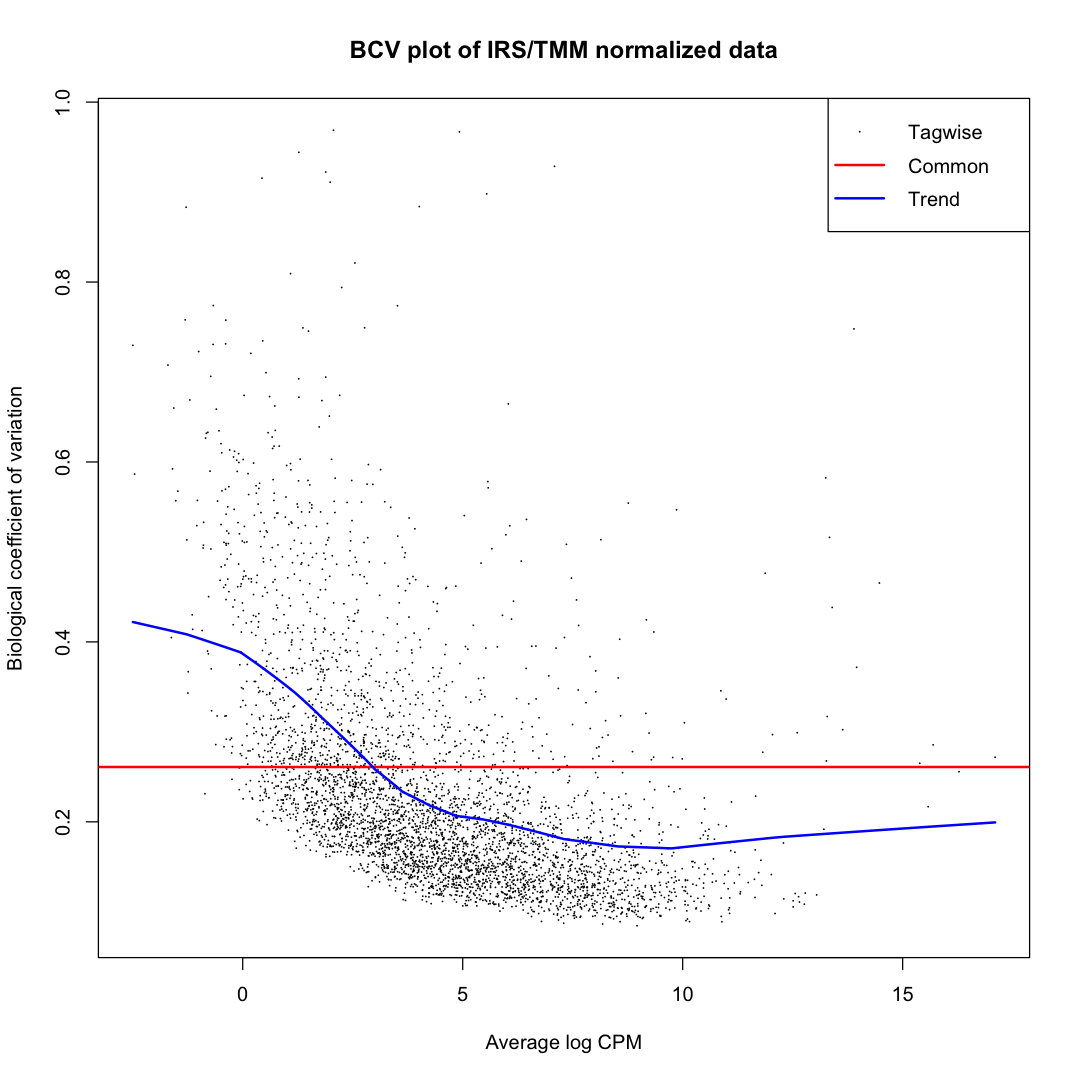

In [21]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

## <a name="Age"></a>Younger lenses (n=6) versus older lenses (n=6)

Compare younger (E15 and E18) lenses to older (P6 and P9) lenses.

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `topTags` table show us the most significant candidates (top 10). We can also summarize how many up and down regulated candidates we have at an FDR of 0.10.  We save the test results in `tt`. We use a handy MA (mean-average) plotting function from `limma` to visualize the DE candidates and check the p-value distribution.


                           genes  logFC logCPM    PValue       FDR
101         sp|P16460|ASSY_MOUSE  2.266 10.492 2.240e-30 9.519e-27
239        sp|O70250|PGAM2_MOUSE  1.977  9.239 2.131e-29 4.528e-26
451        sp|O70400|PDLI1_MOUSE  1.278  8.258 1.463e-23 1.632e-20
524        sp|Q62433|NDRG1_MOUSE  2.745  7.497 1.536e-23 1.632e-20
460        sp|P99029|PRDX5_MOUSE  1.348  7.954 2.191e-22 1.772e-19
1661        sp|P97494|GSH1_MOUSE  1.945  5.442 2.502e-22 1.772e-19
260         sp|P21550|ENOB_MOUSE  1.560  9.039 6.127e-22 3.572e-19
3012        sp|Q7TNP2|2AAB_MOUSE -1.486  2.849 6.725e-22 3.572e-19
11   sp|Q9CXV3|CRGF_MOUSE_family  1.565 13.209 1.109e-21 5.234e-19
54          sp|P04342|CRGD_MOUSE  1.795 11.109 5.162e-21 2.194e-18

       old-young
Down        1167
NotSig      2002
Up          1080


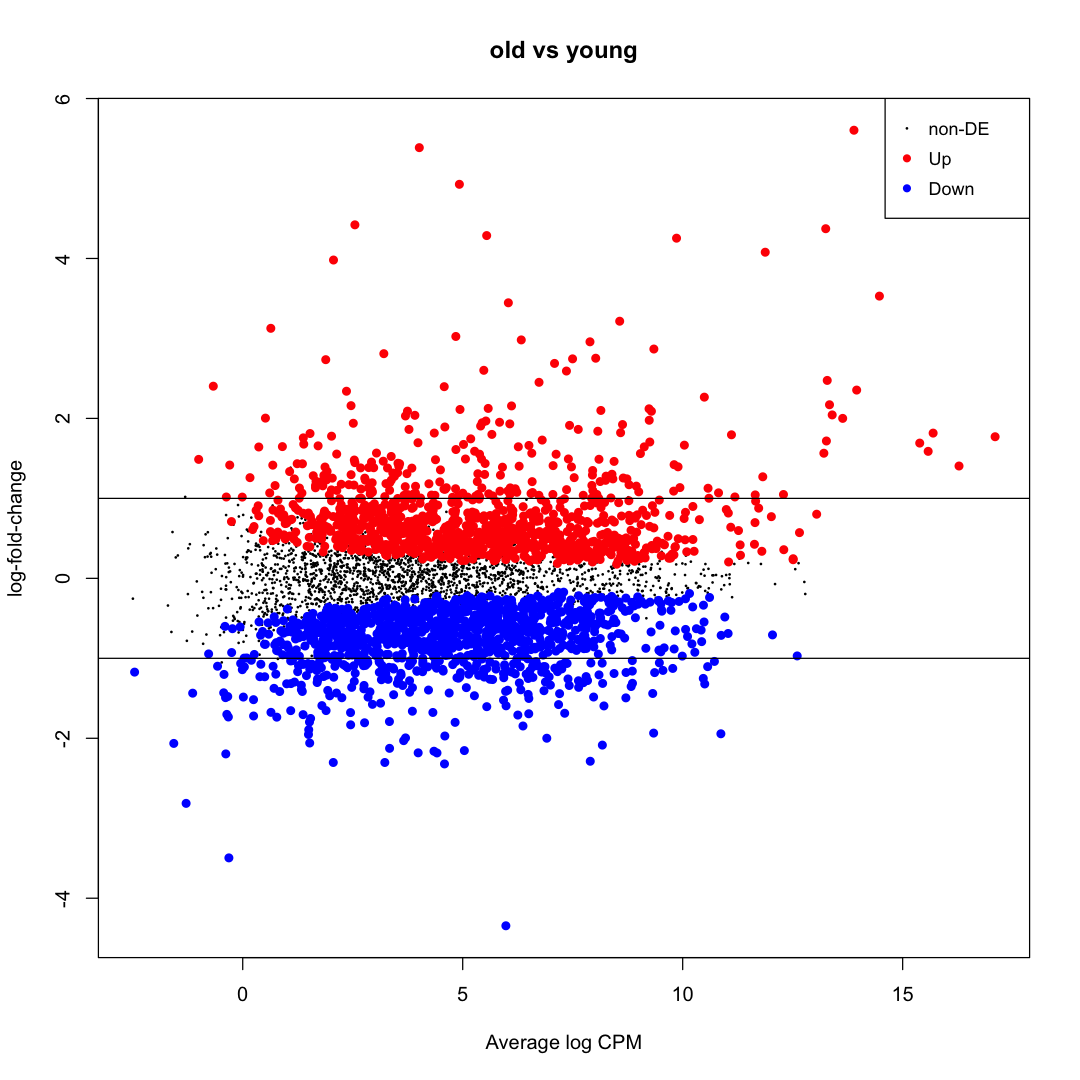

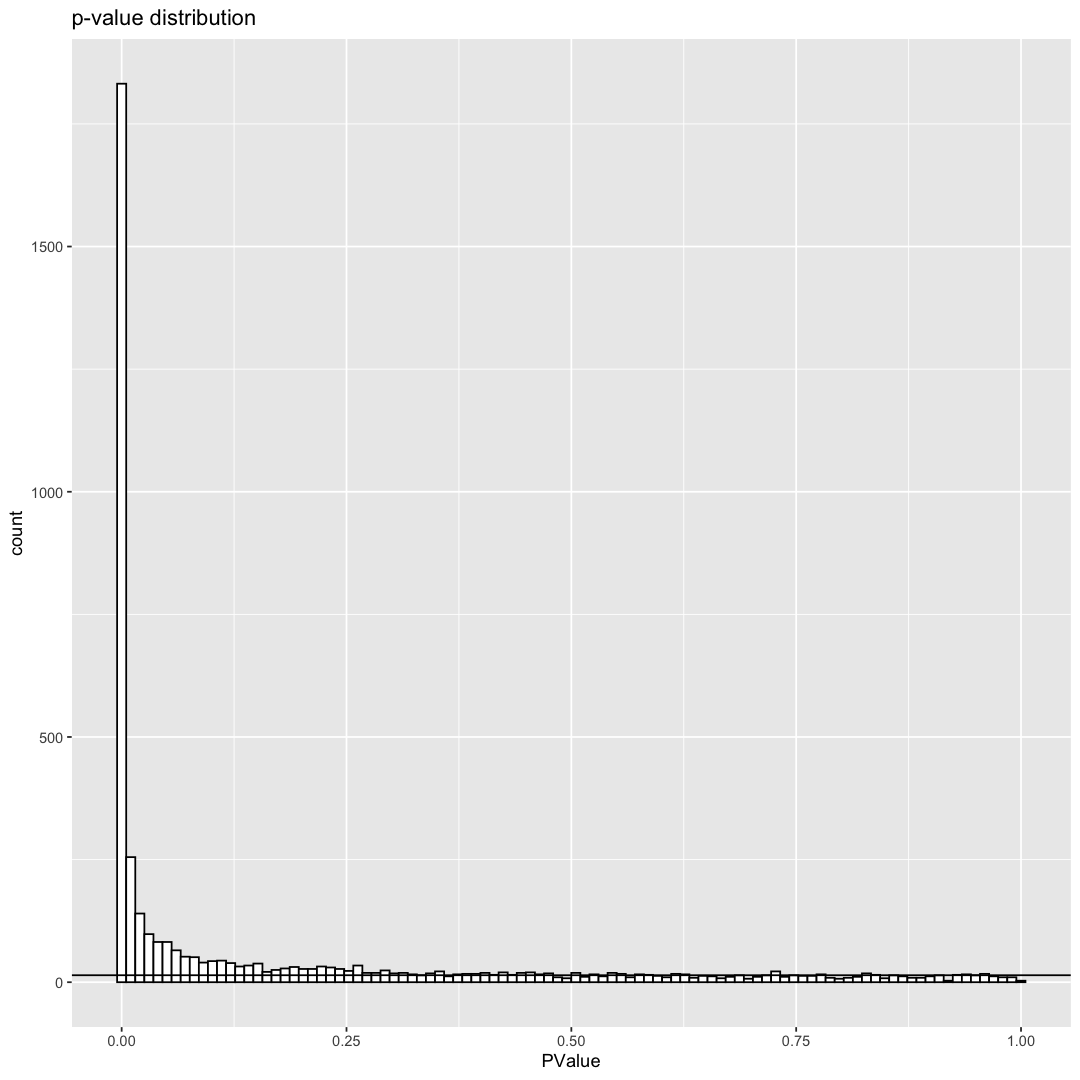

In [22]:
# use a 0.05 cutoff
tt = pairwise_test(y, c("young", "old"), 0.05)

### We have around 1,000 DE candidates in each direction

There is a nice balance between up (red) and down (blue) candidates (about 1K each) with 2K unchanged proteins. Many candidates have abundance levels that are different from the unchanged proteins (black points in the MA plot). The p-value distribution has a typical pattern of two distributions. There is a uniform (flat) distribution of p-values from 0 to 1 from chance associated with unchanged proteins. There is a sharp excess of small p-values that come from the (putative) DE candidates. 

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and accumulate all comparisons into `all_results`.

We will make MA plots, scatter plots, and a volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [23]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, young, "young", old, "old")

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_Y_O")

# accumulate testing results
all_results <- cbind(accessions, results_temp)

### Count candidates and look at fold-change distributions


  candidate    n
1      high 1789
2       med  458
3       low  263
4        no 1739



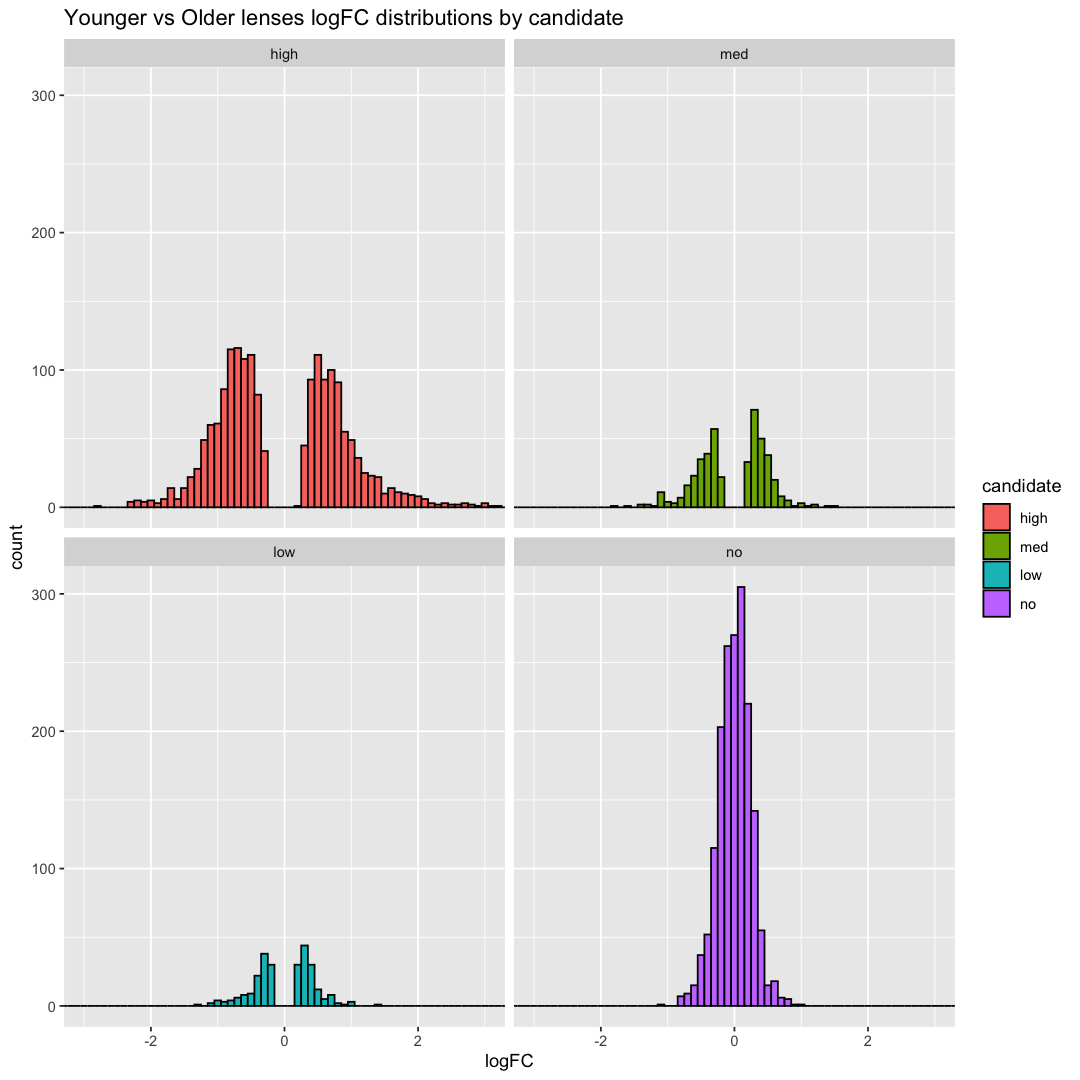

In [24]:
# count candidates and check log2 fold change distributions
log2_fold_changes(results, 3, 3, "Younger vs Older lenses logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

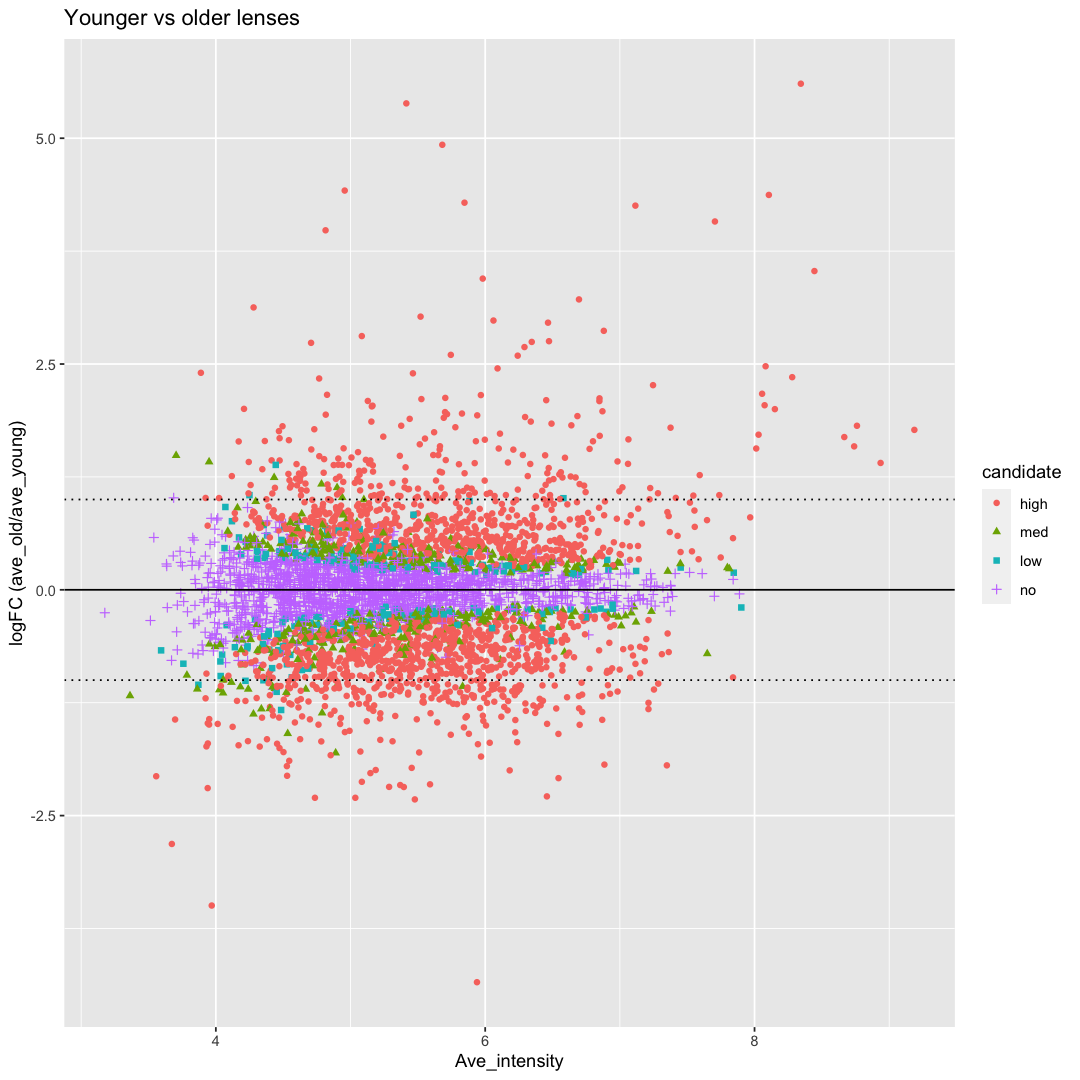

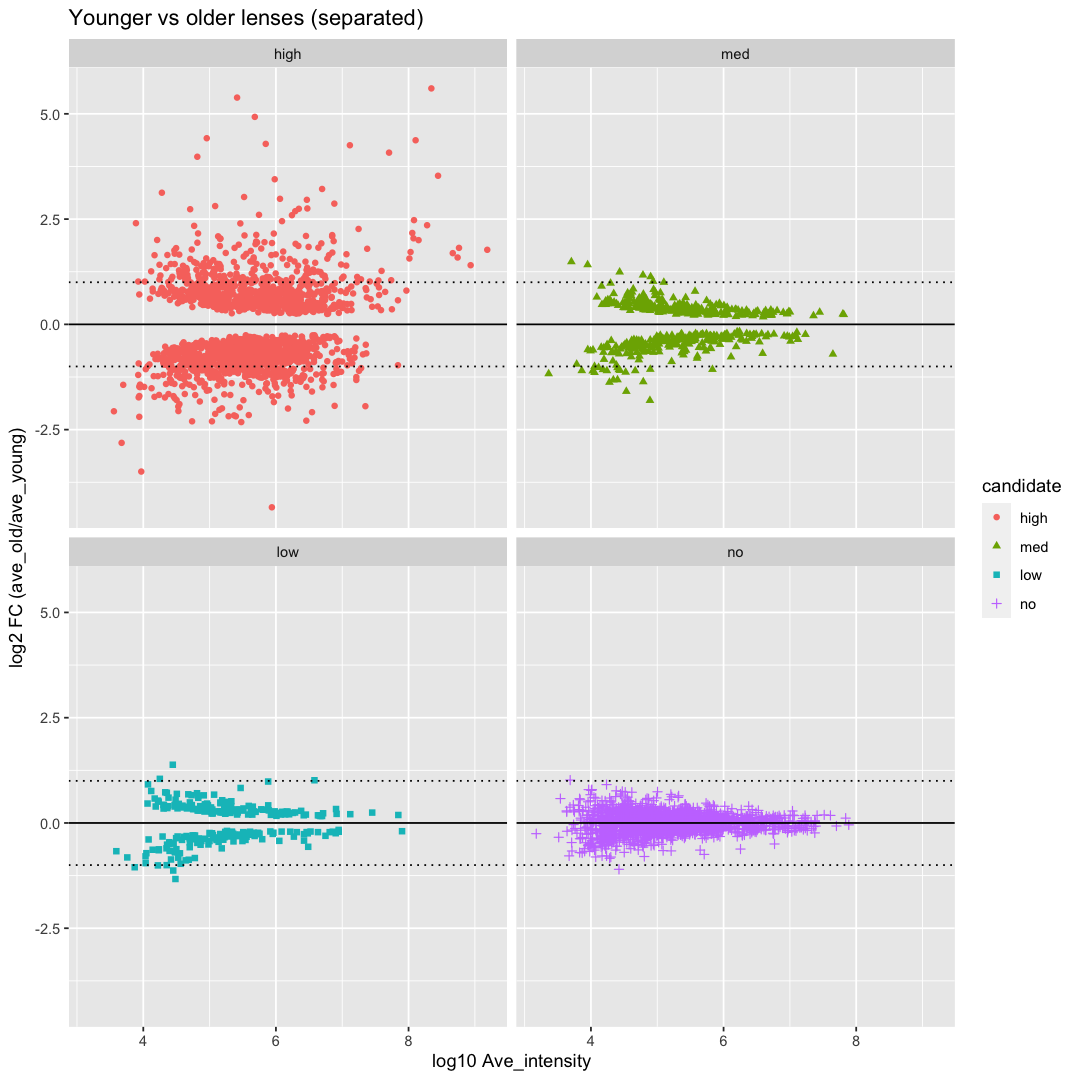

In [25]:
# make MA plots
MA_plots(results, "ave_young", "ave_old", "Younger vs older lenses")

### The non-candidates and candidates have a typical pattern

We see a nice pattern of increasing fold changes as we cut candidates by increasingly stricter FDR (Benjamini-Hochberg corrected p-values) thresholds. This is more easily seen in the facetted plots (the second panel). 

### Scatter plots

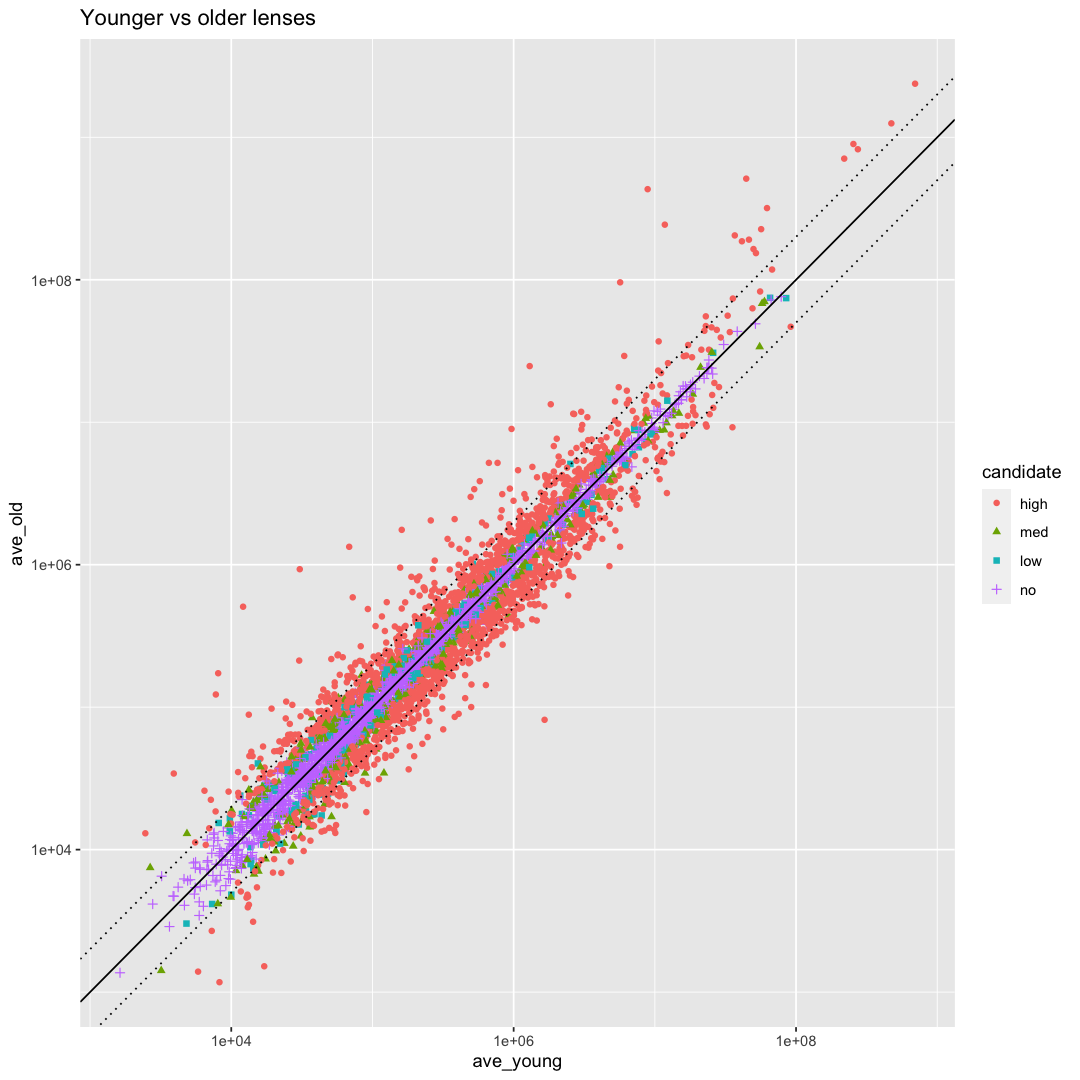

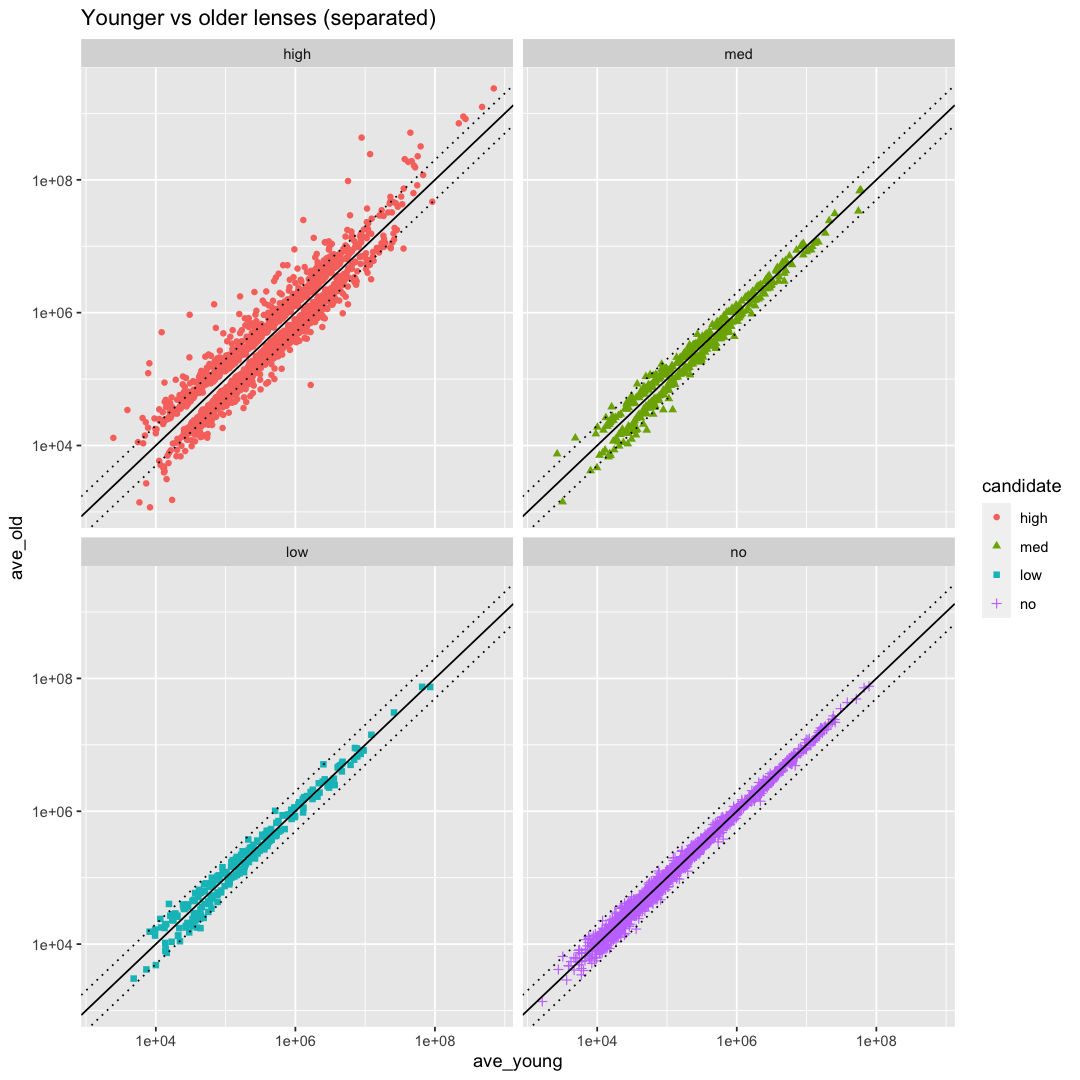

In [26]:
# make scatter plots
scatter_plots(results, "ave_young", "ave_old", "Younger vs older lenses")

### Volcano plot

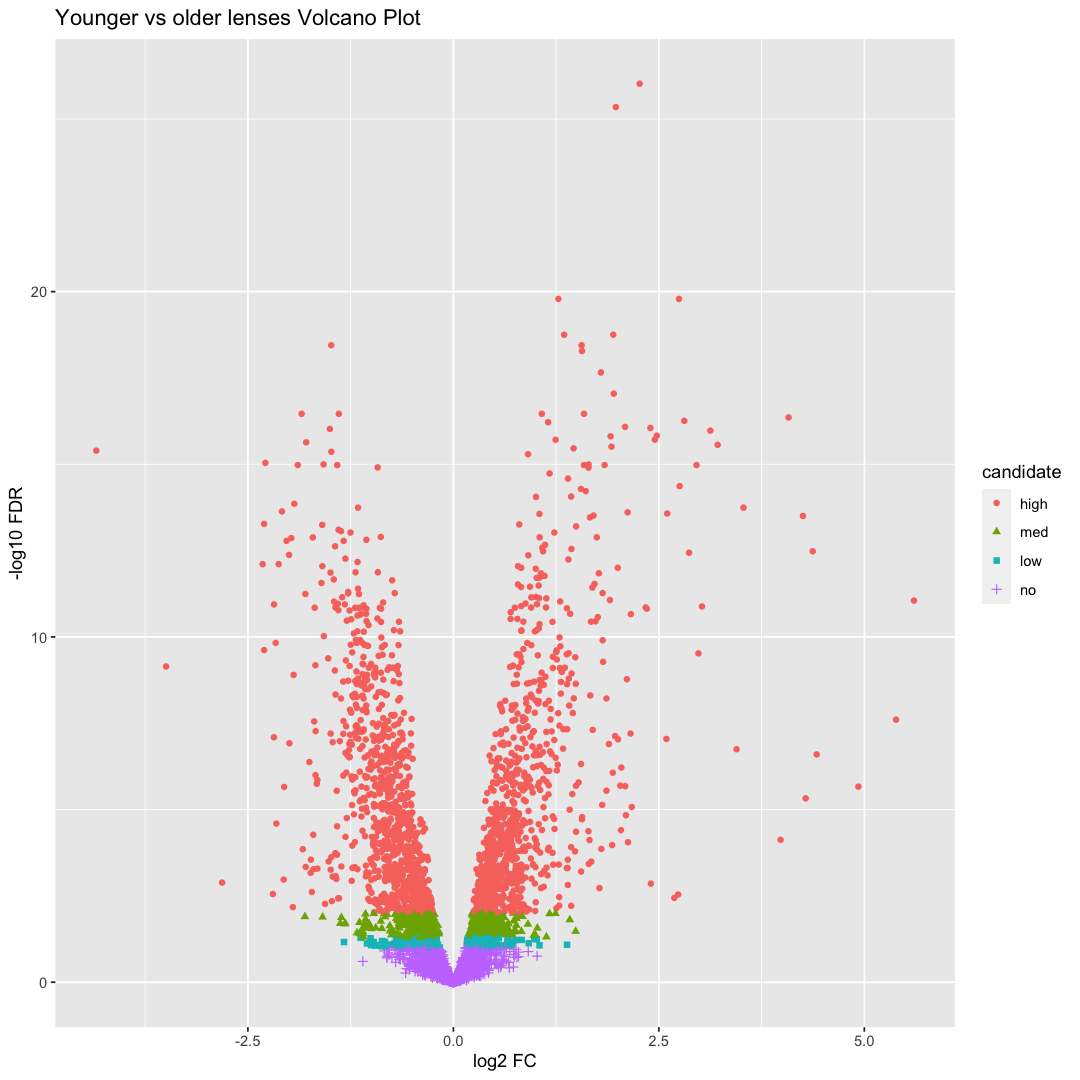

In [27]:
# make a volcano plot
volcano_plot(results, "ave_young", "ave_old", "Younger vs older lenses")

### Check some individual proteins

Since we have many candidates, we will look at the top 50 by p-value in each direction.

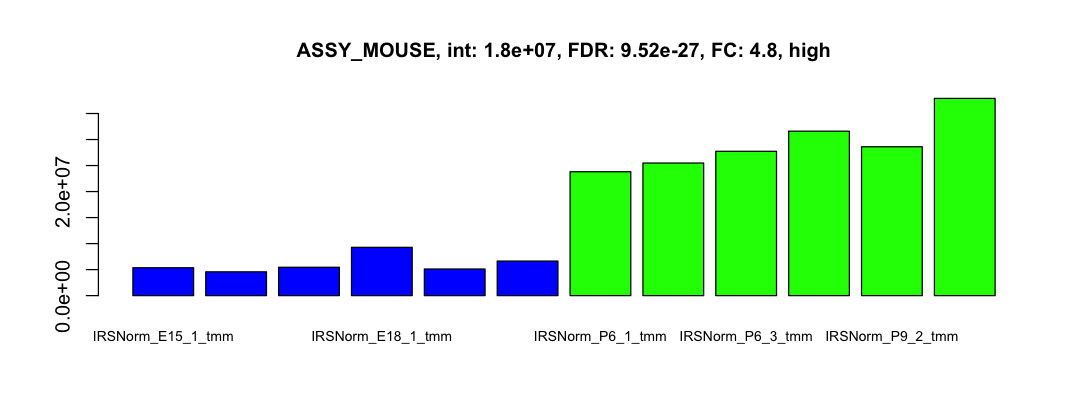

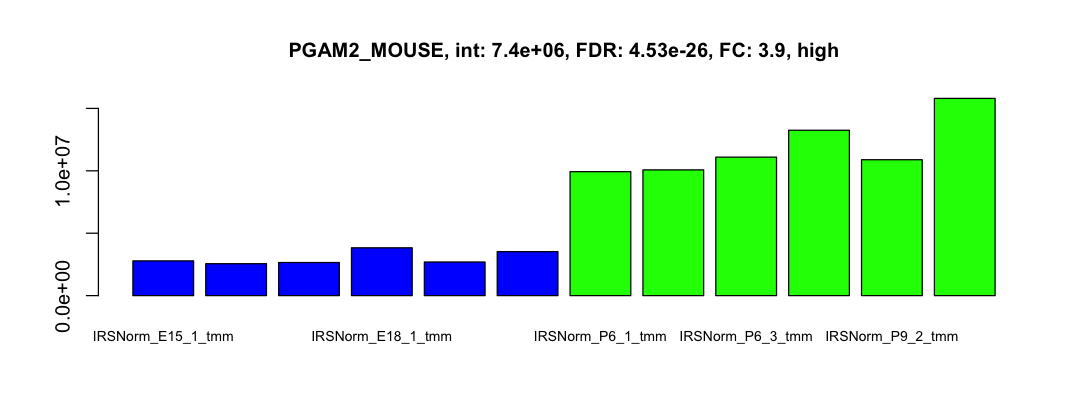

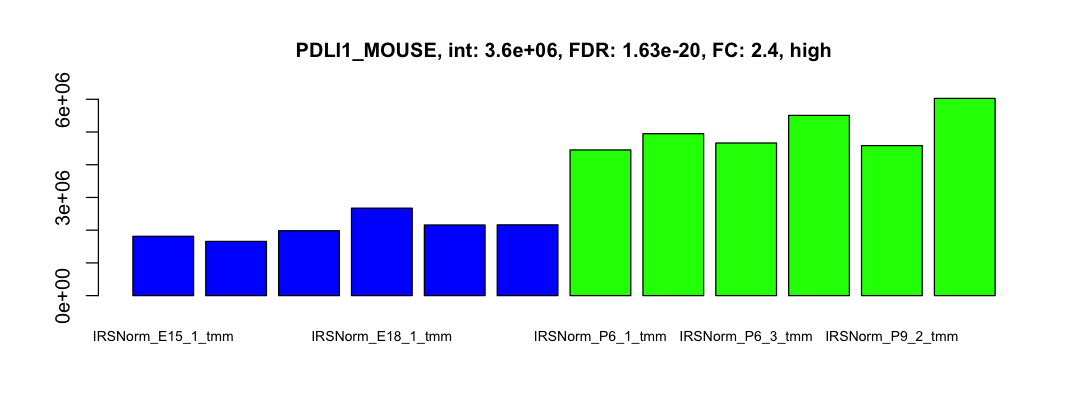

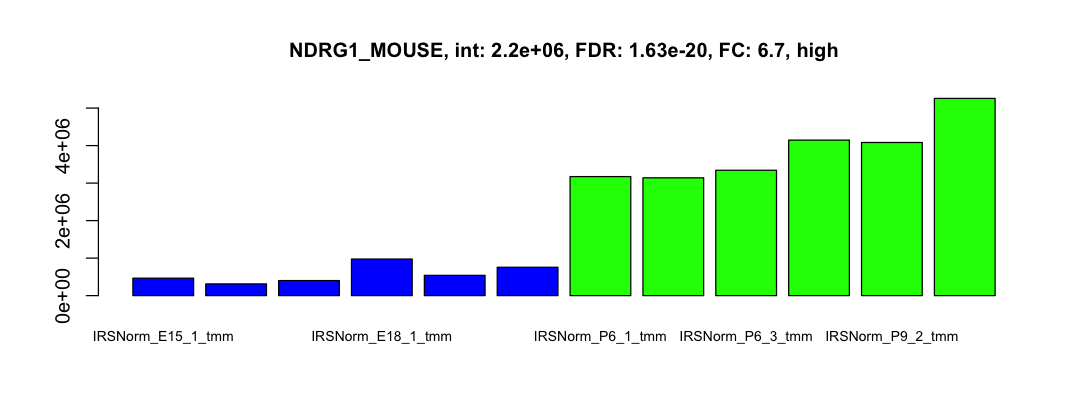

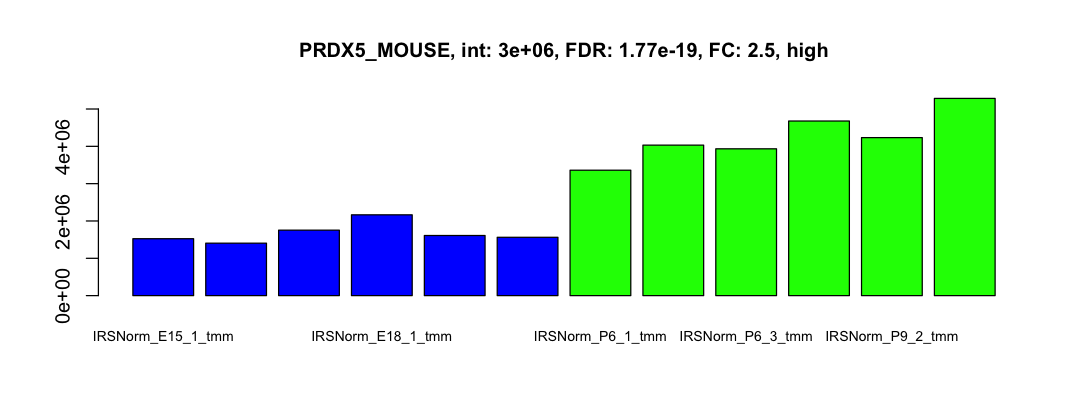

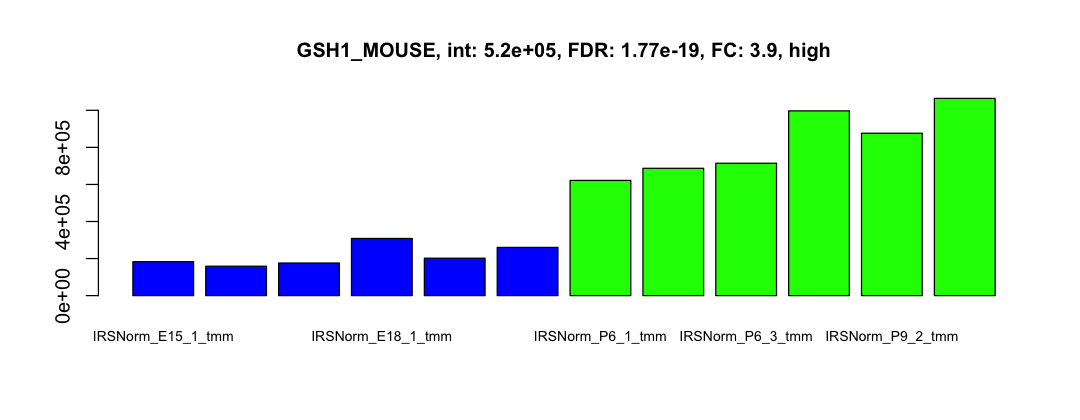

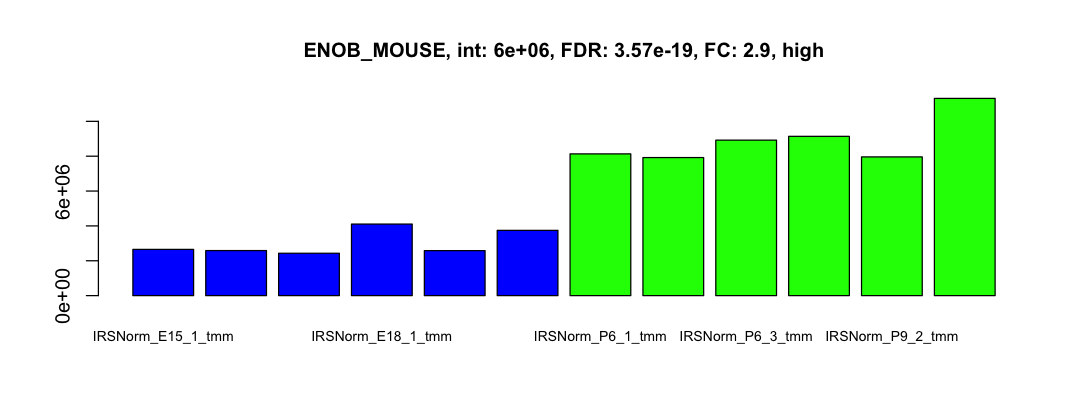

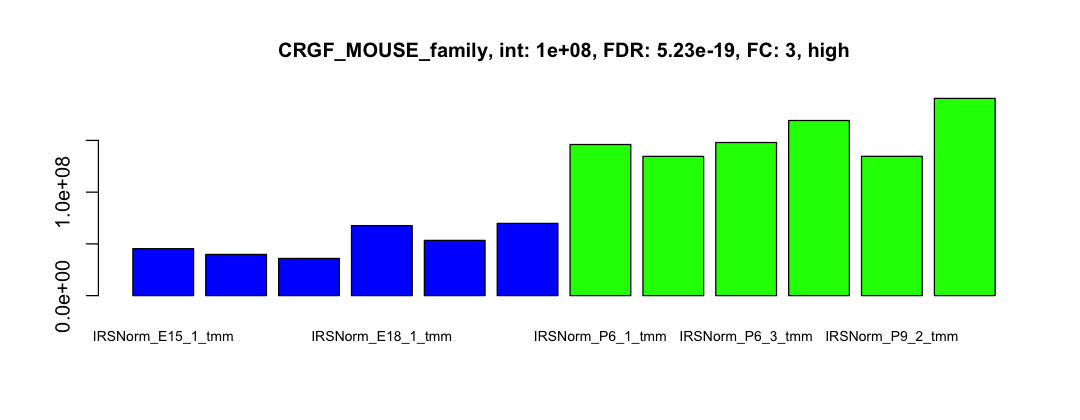

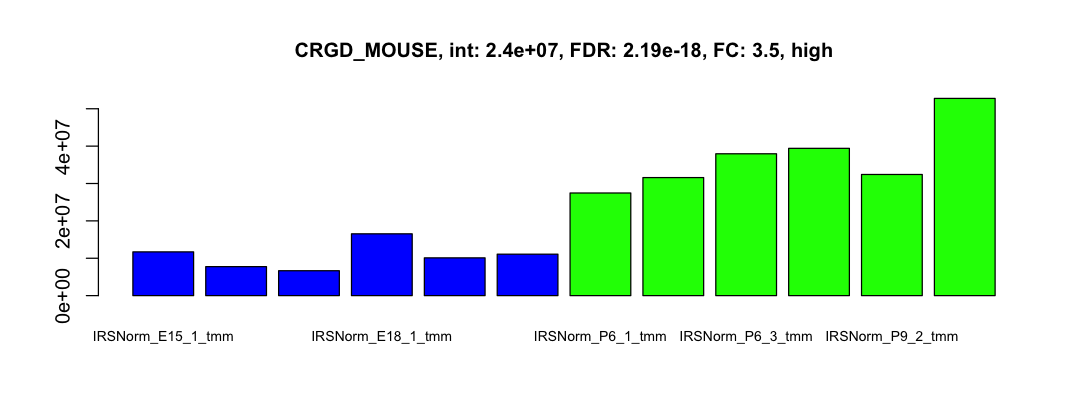

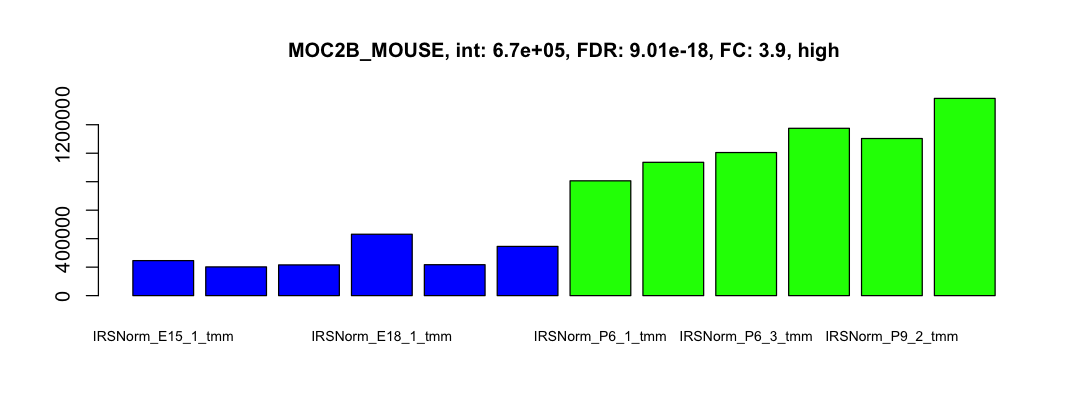

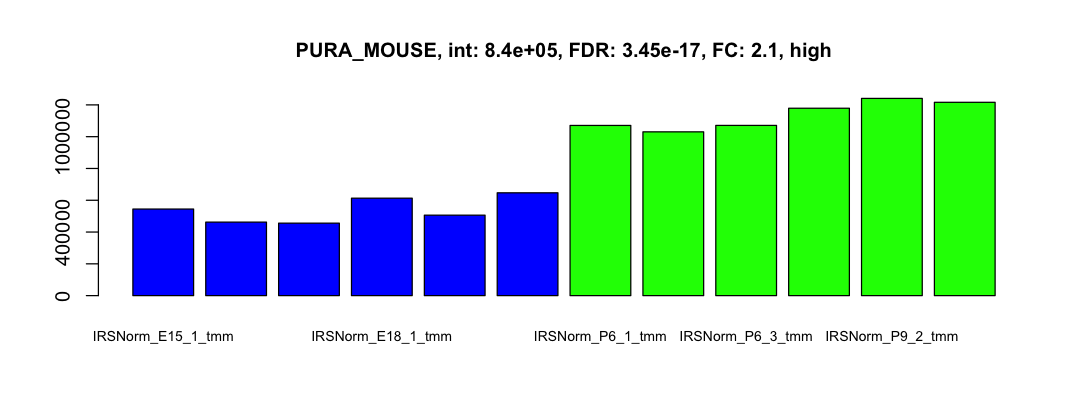

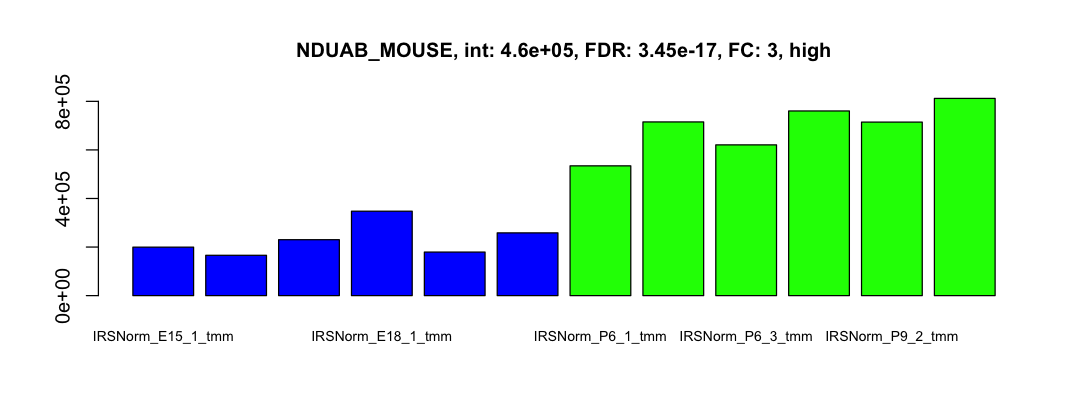

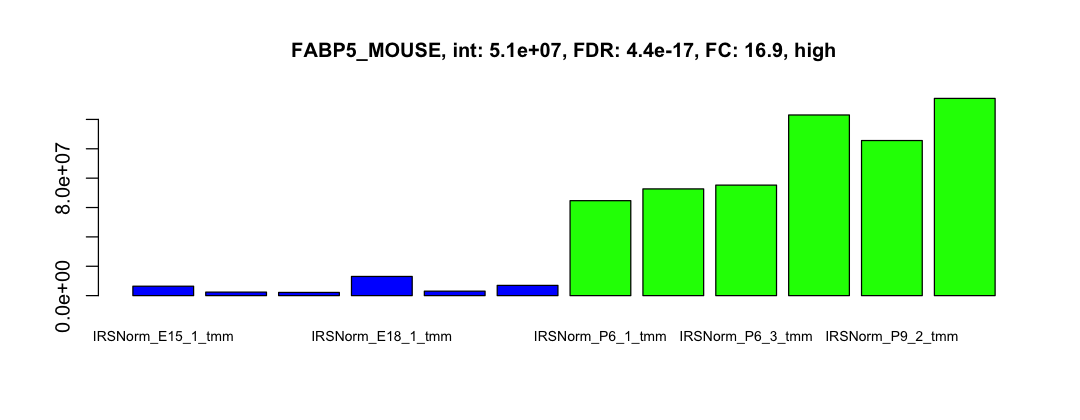

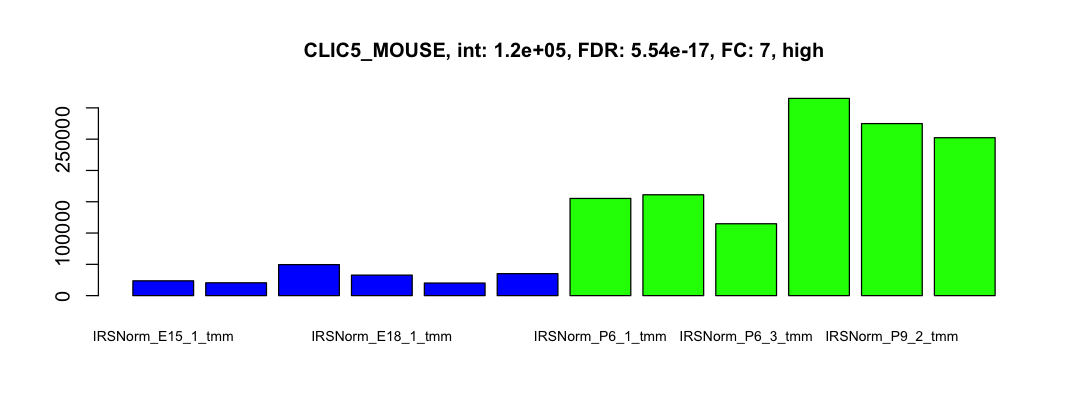

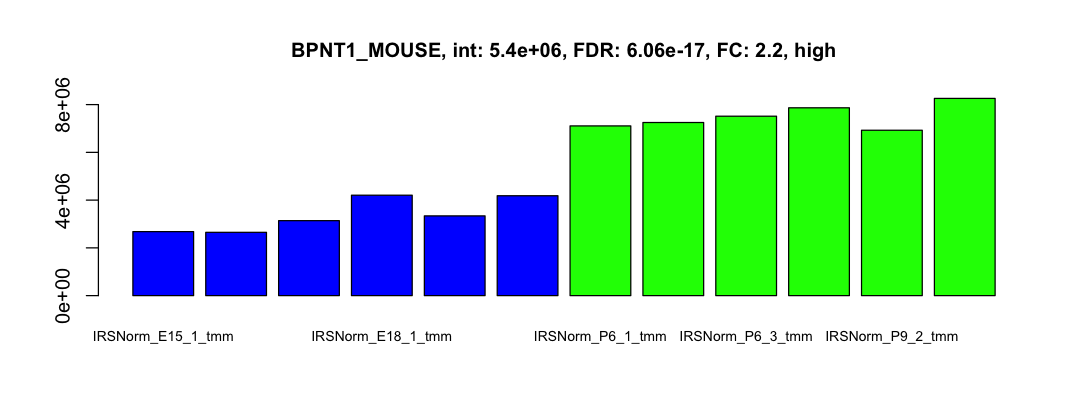

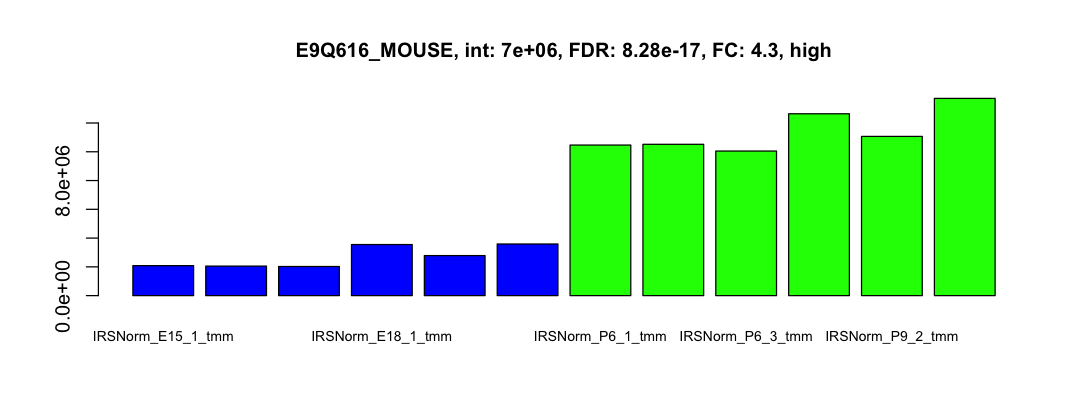

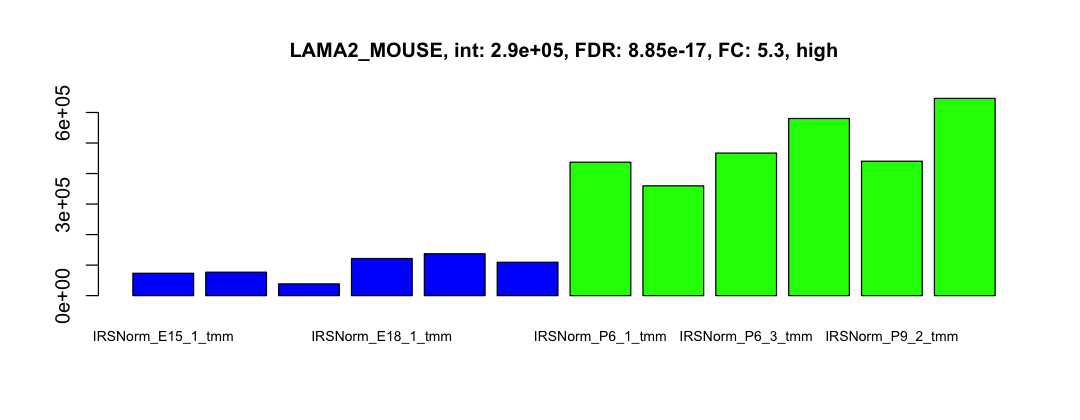

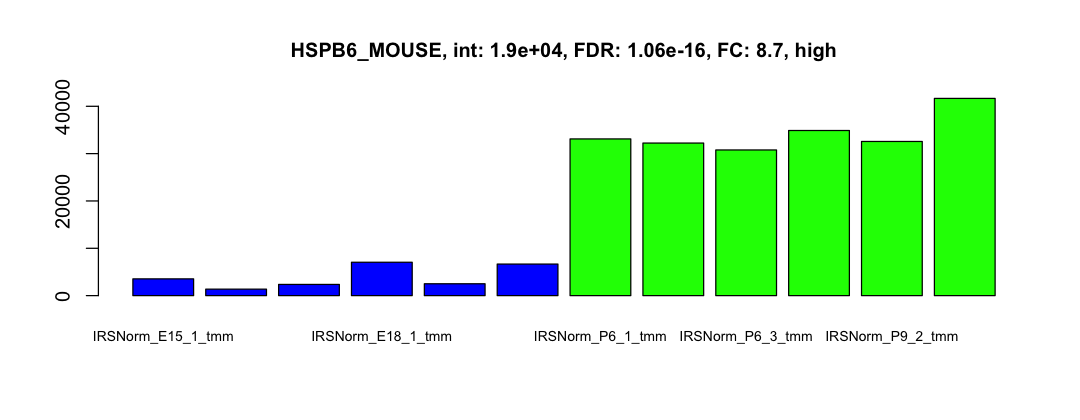

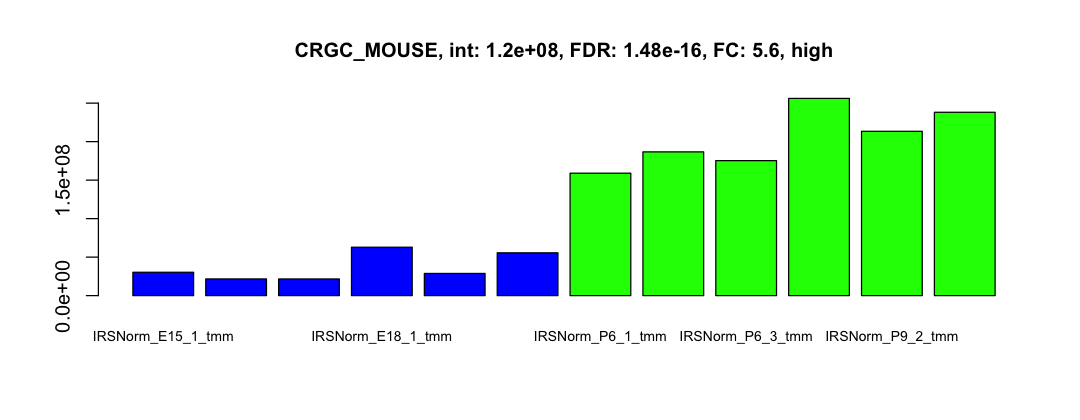

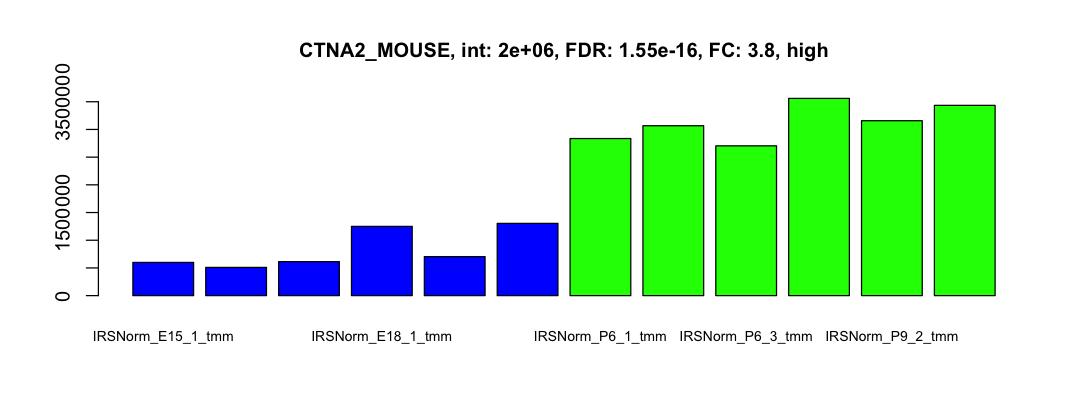

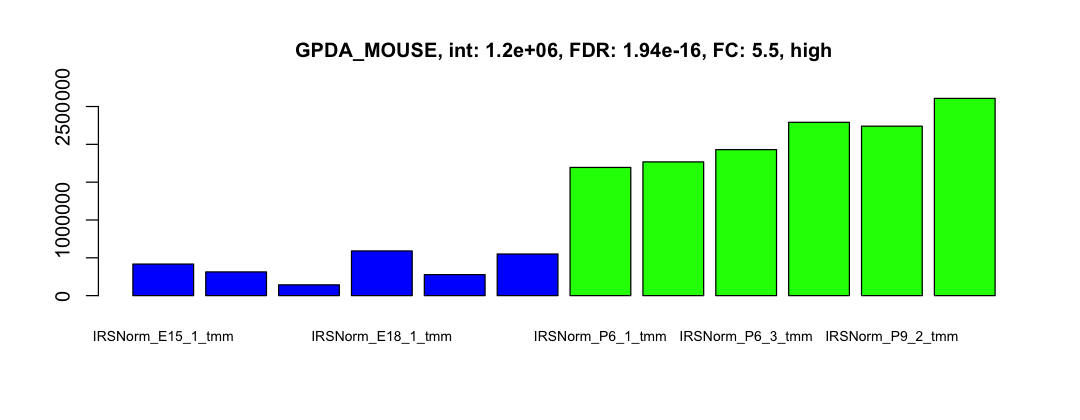

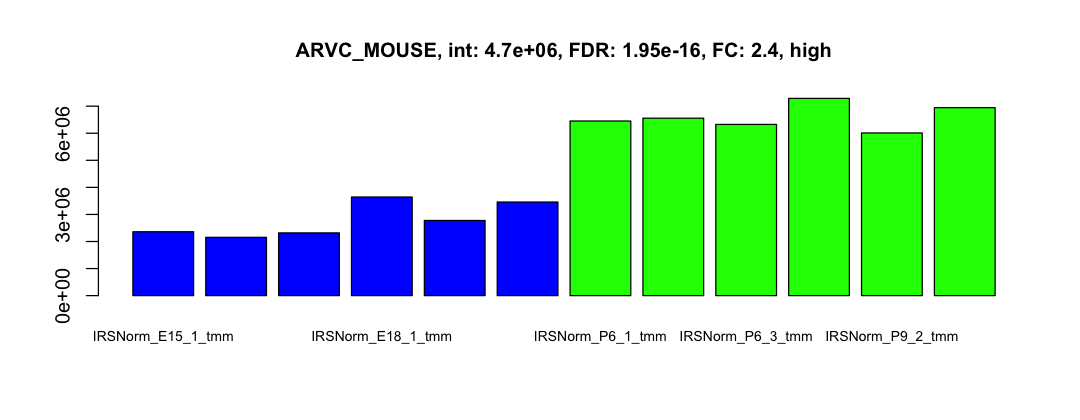

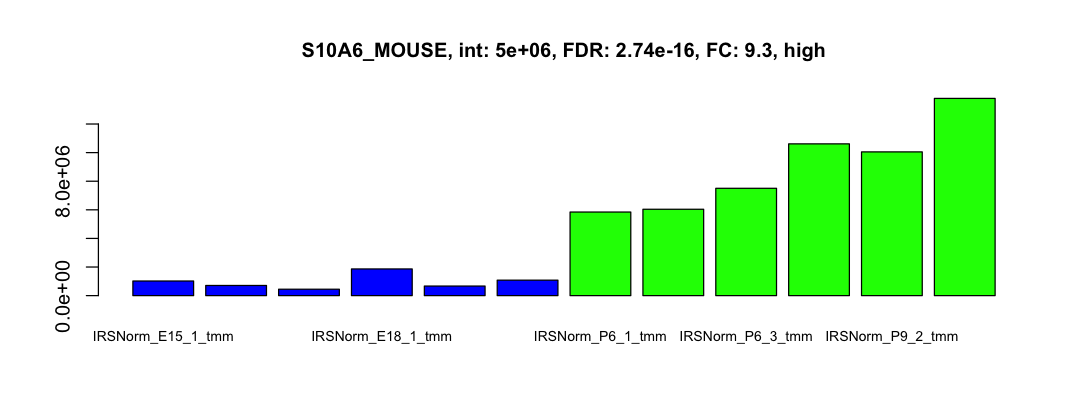

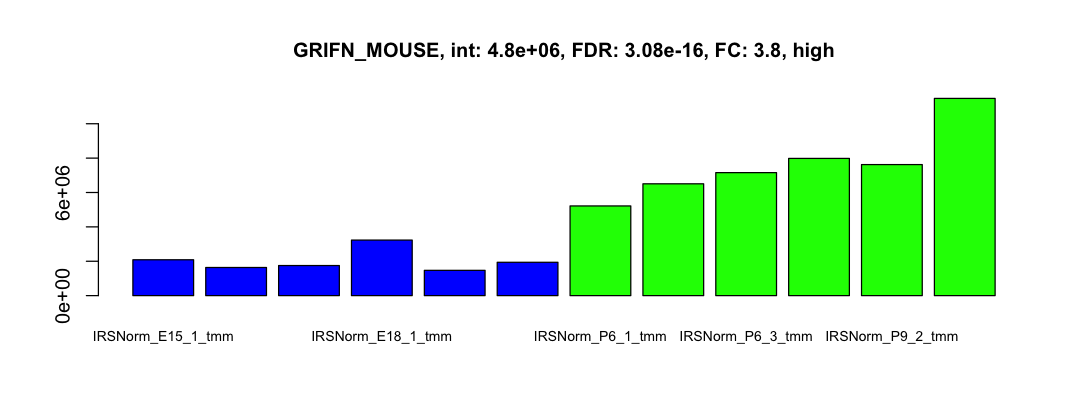

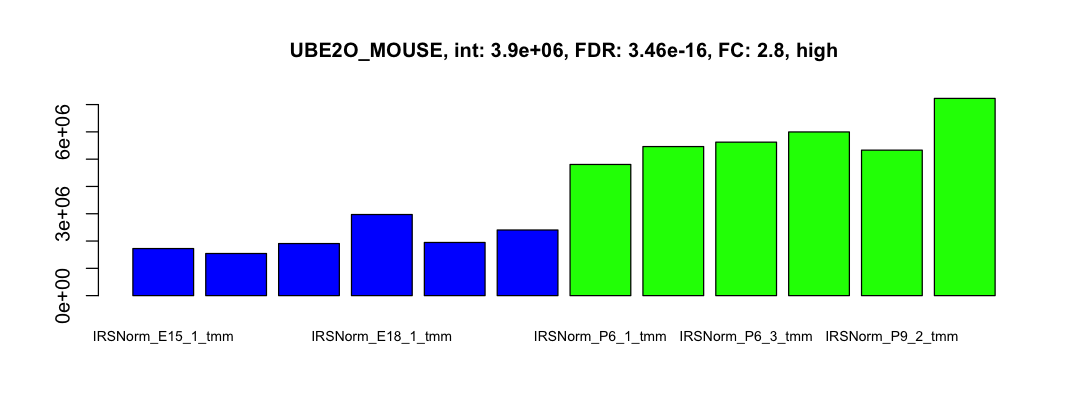

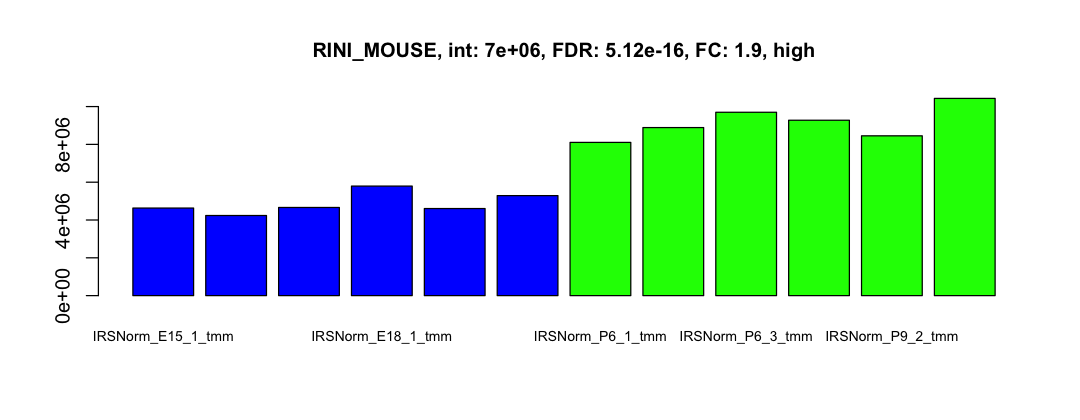

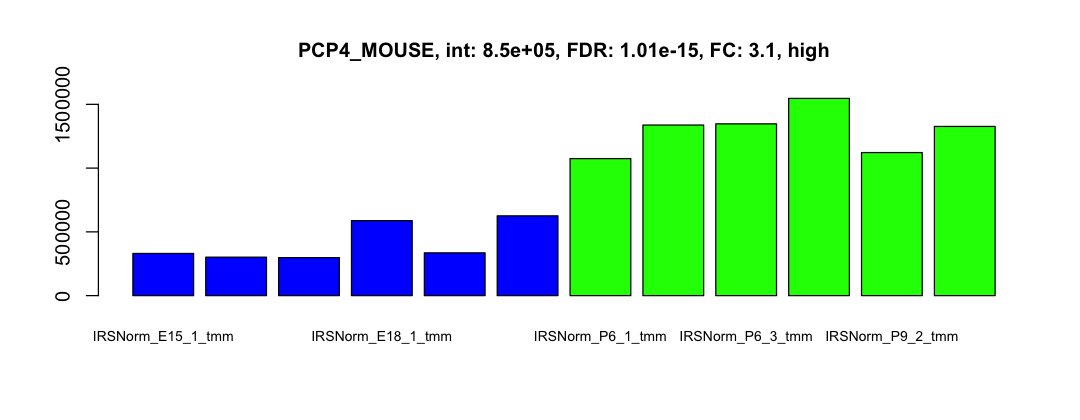

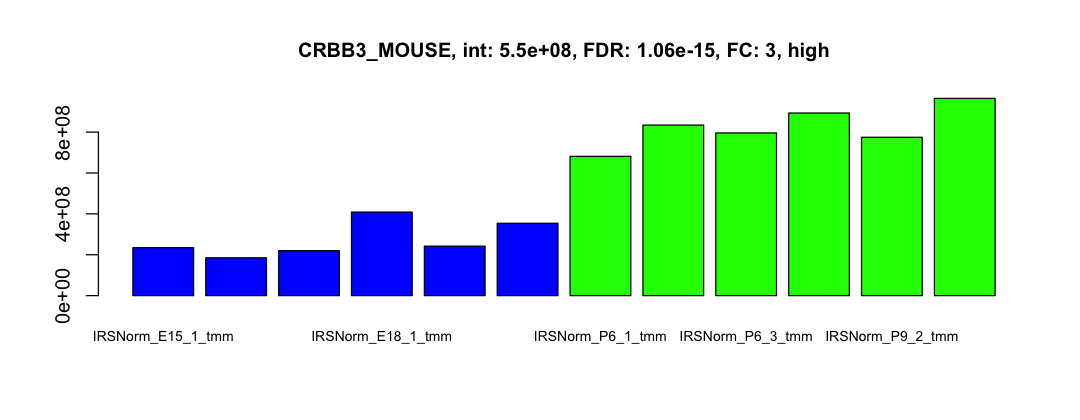

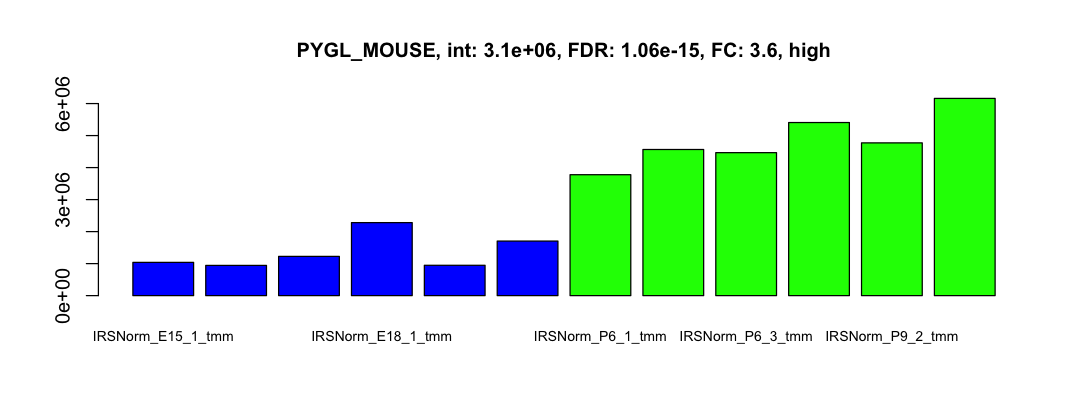

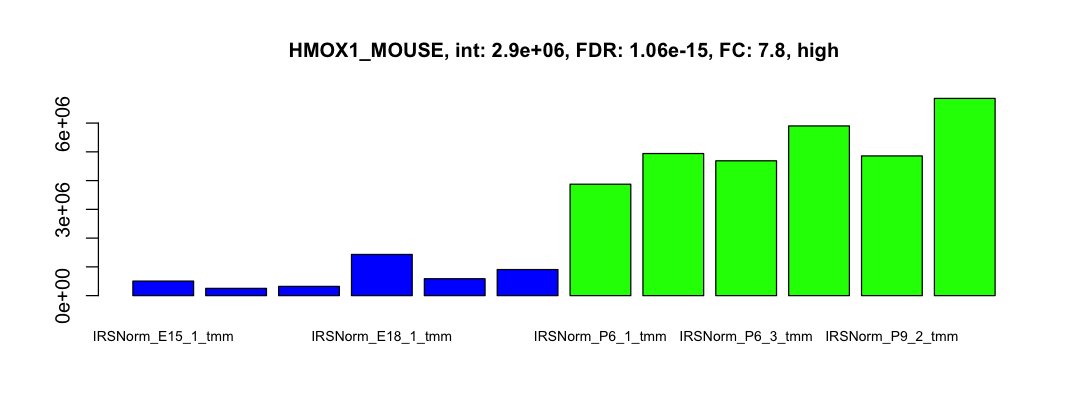

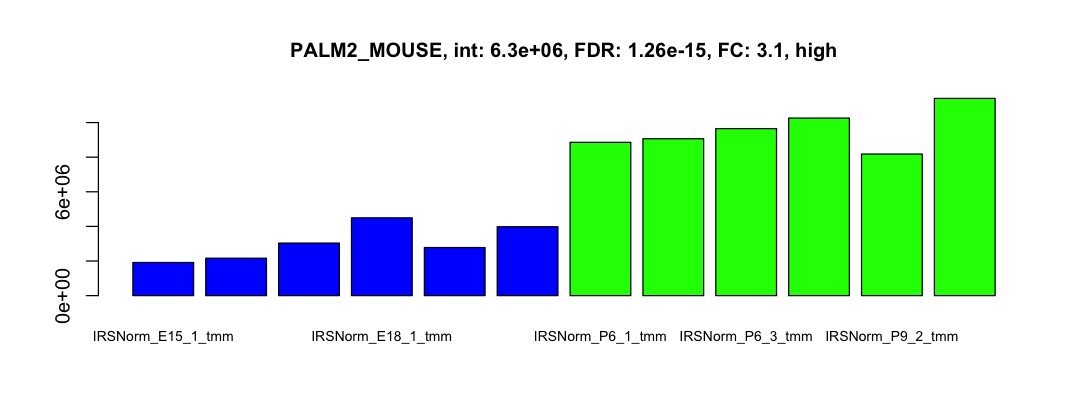

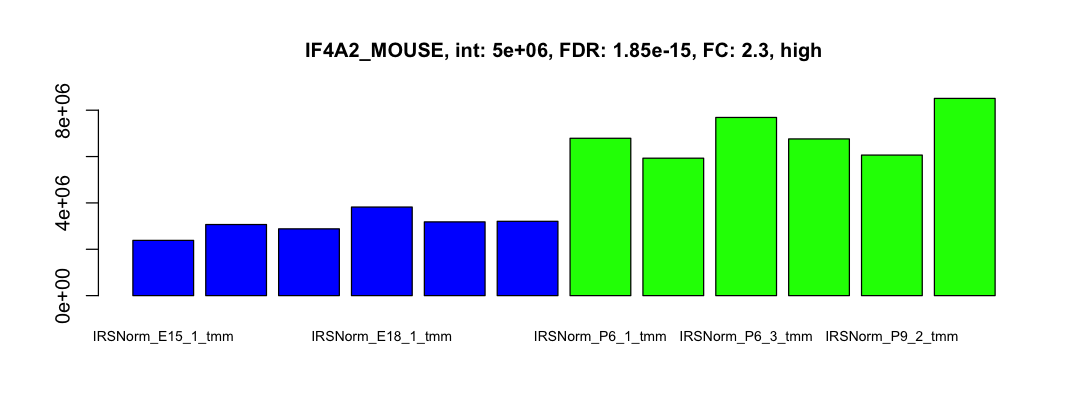

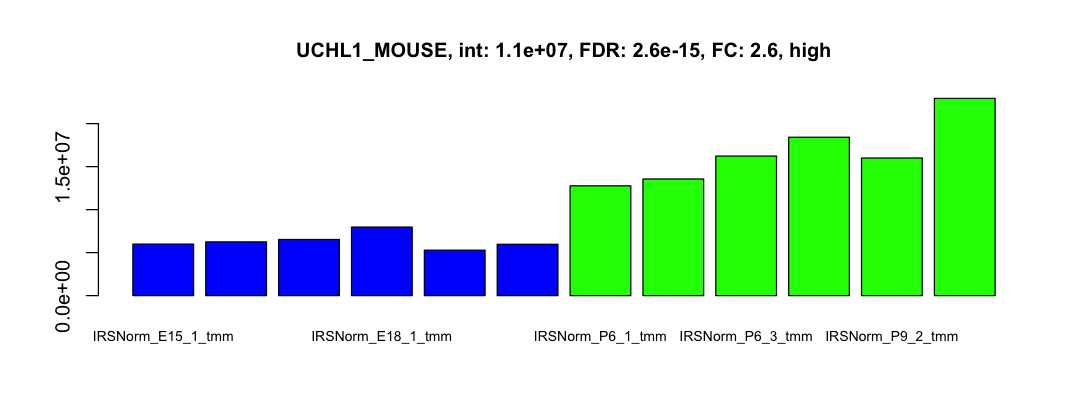

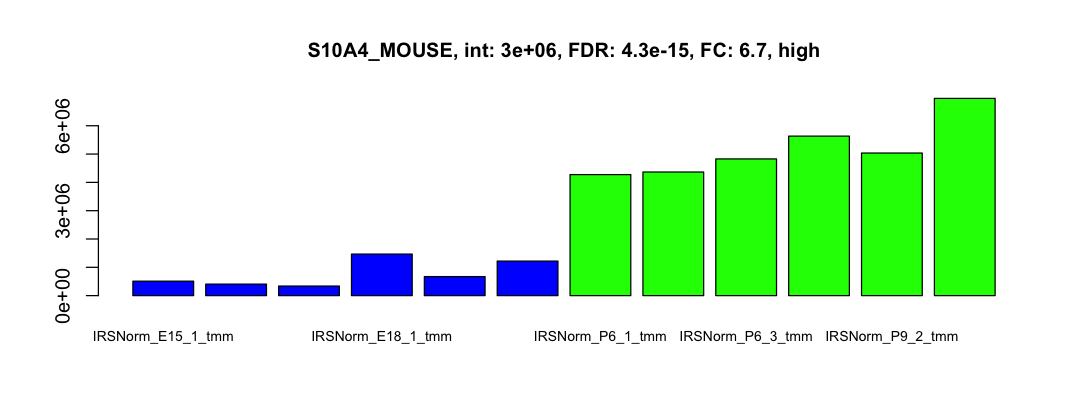

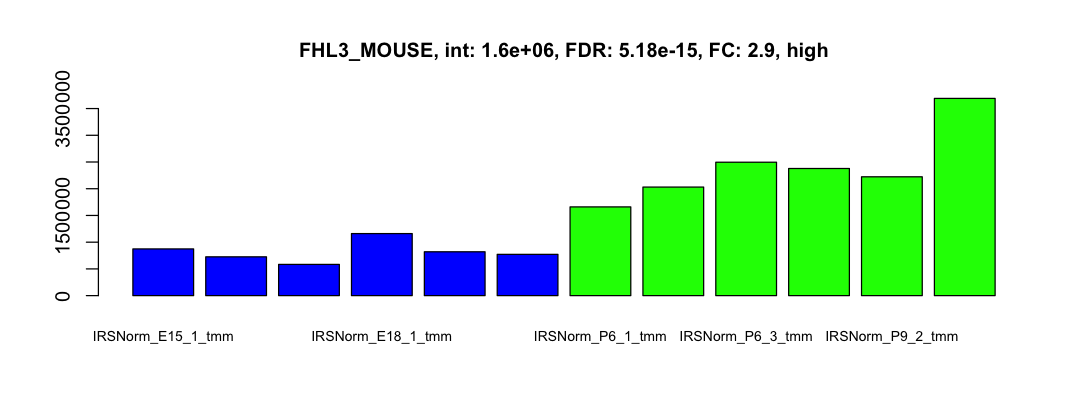

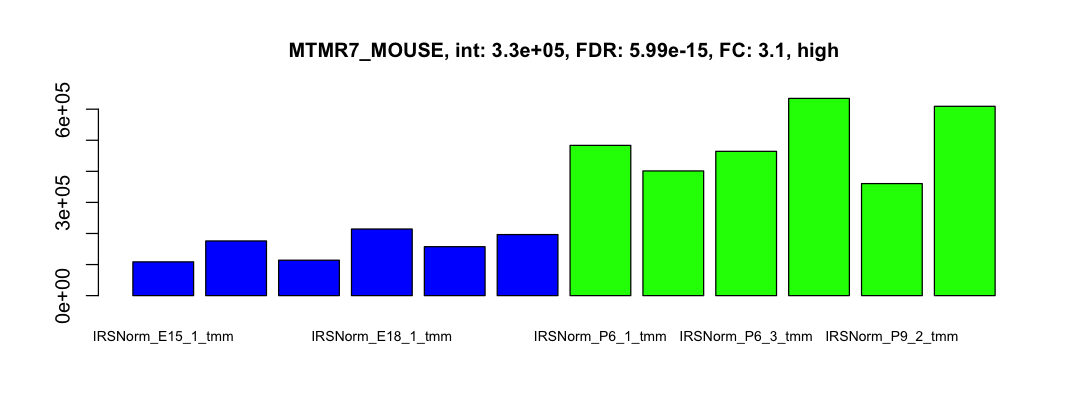

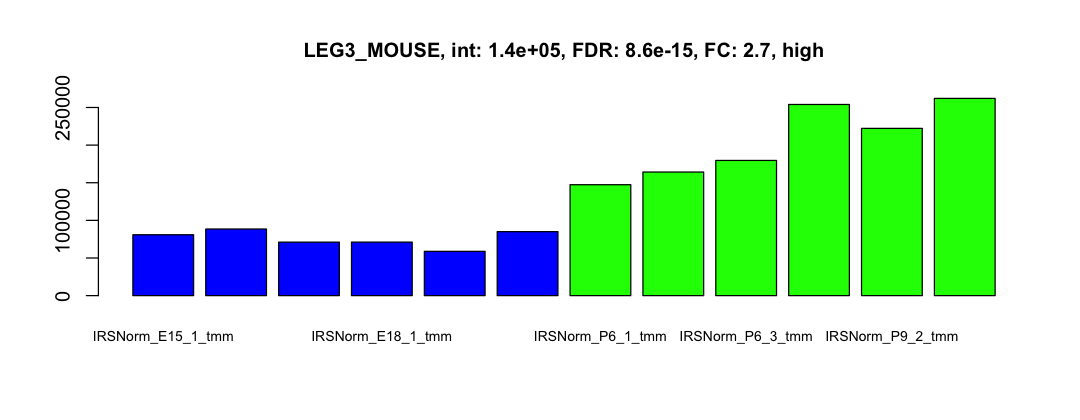

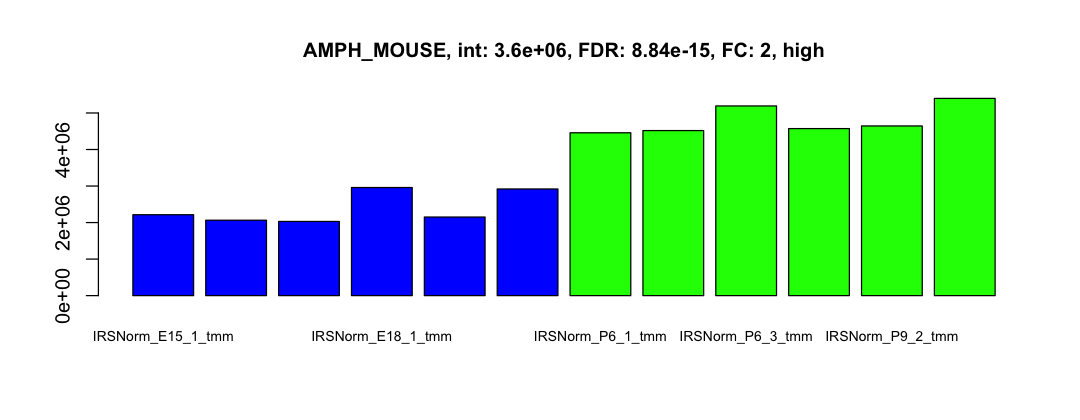

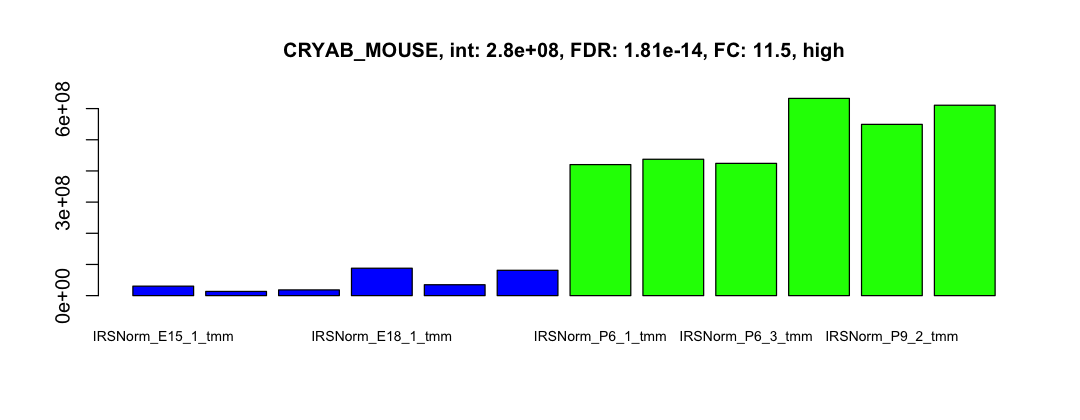

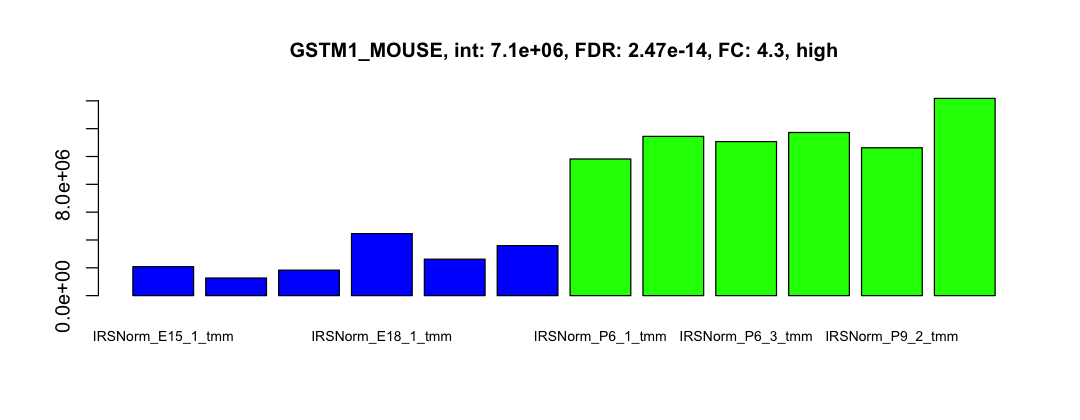

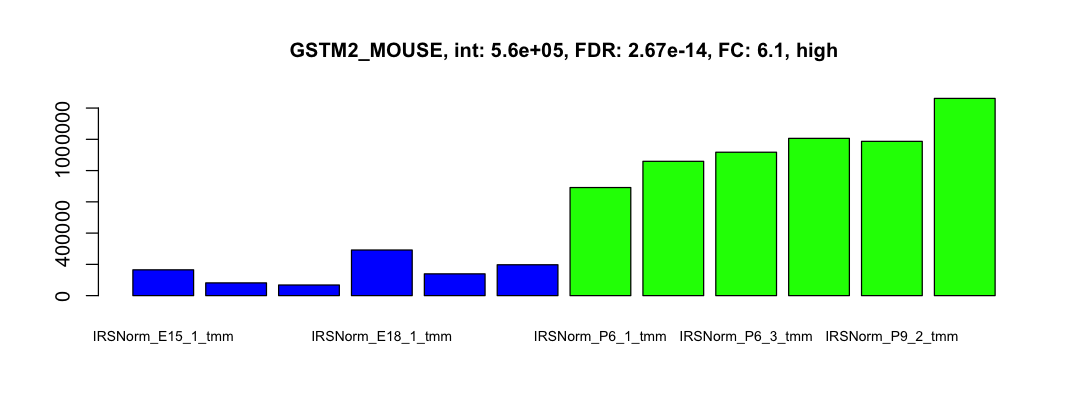

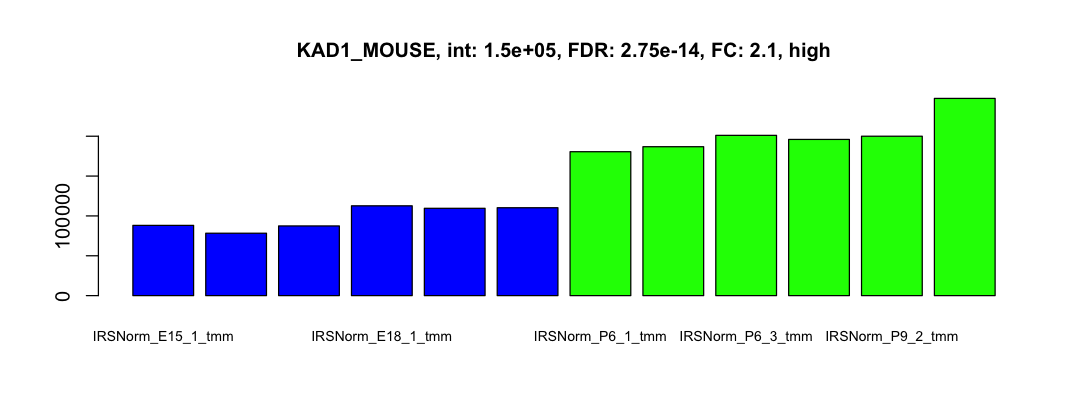

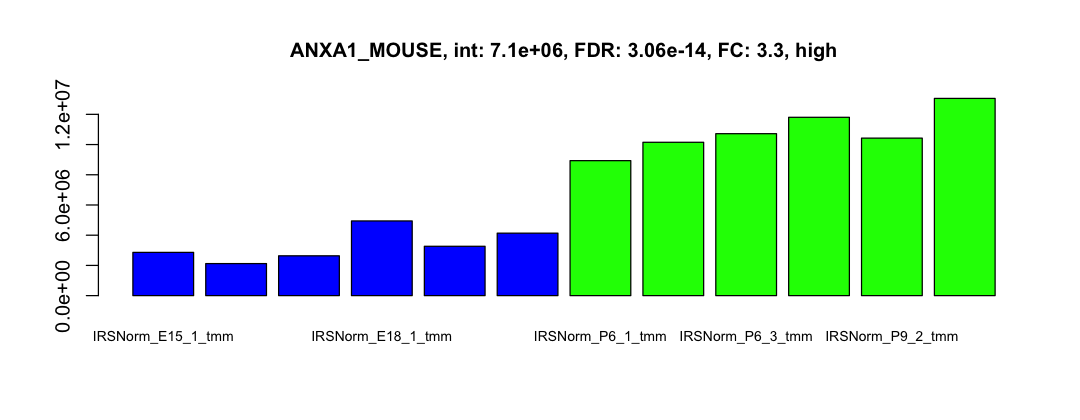

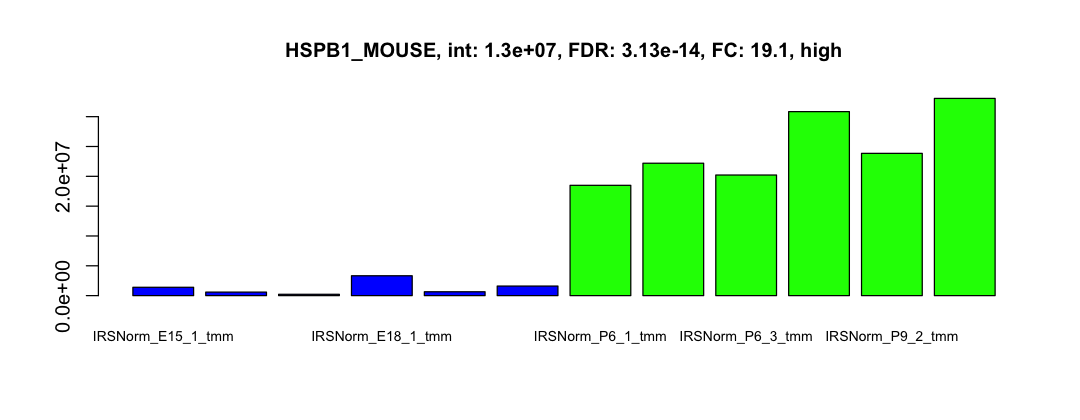

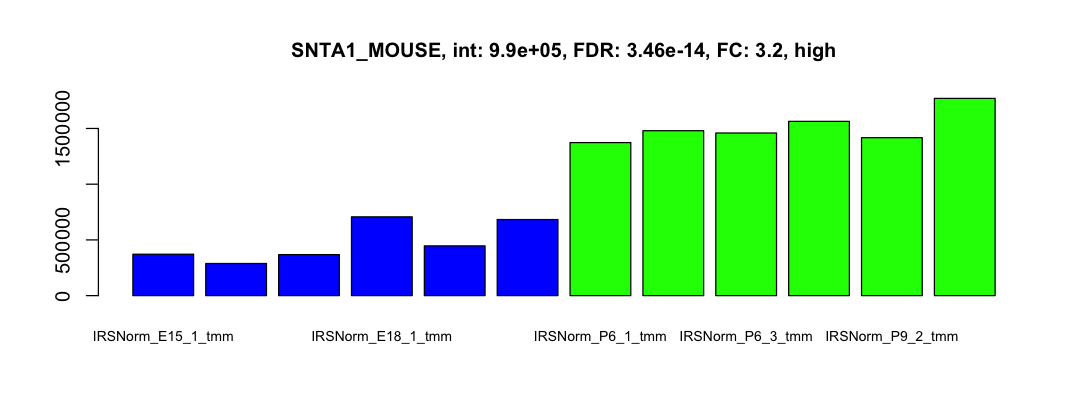

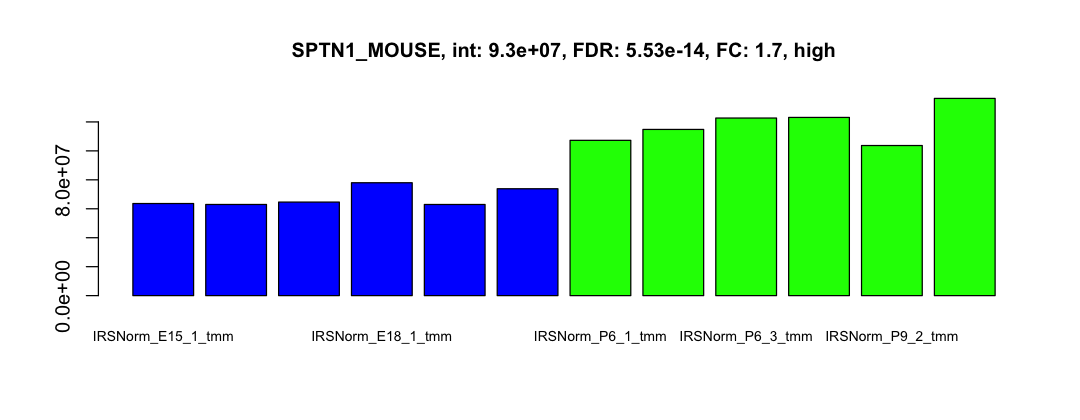

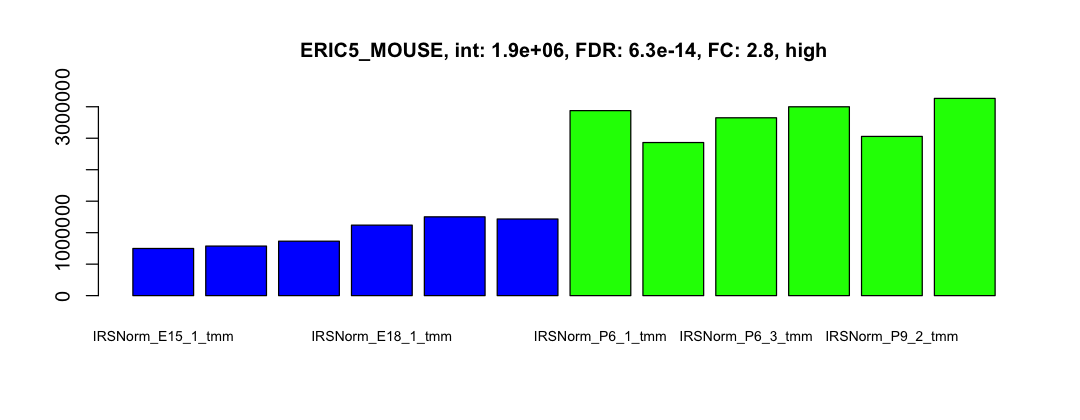

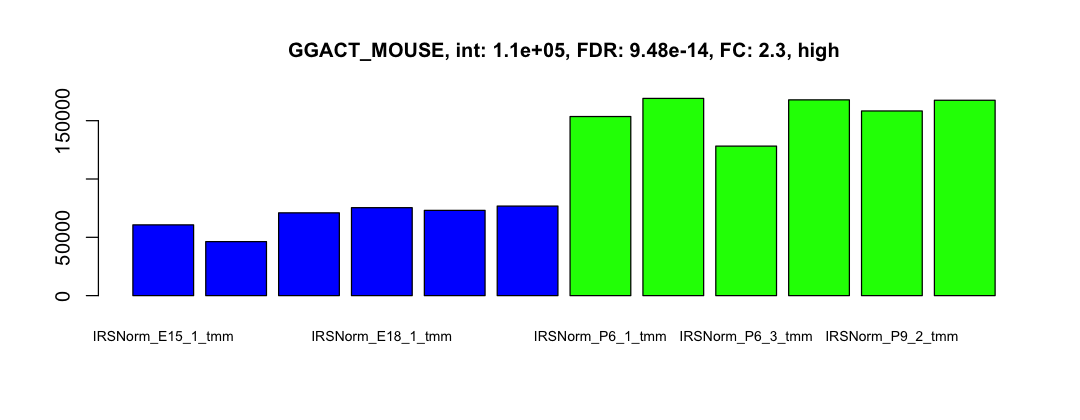

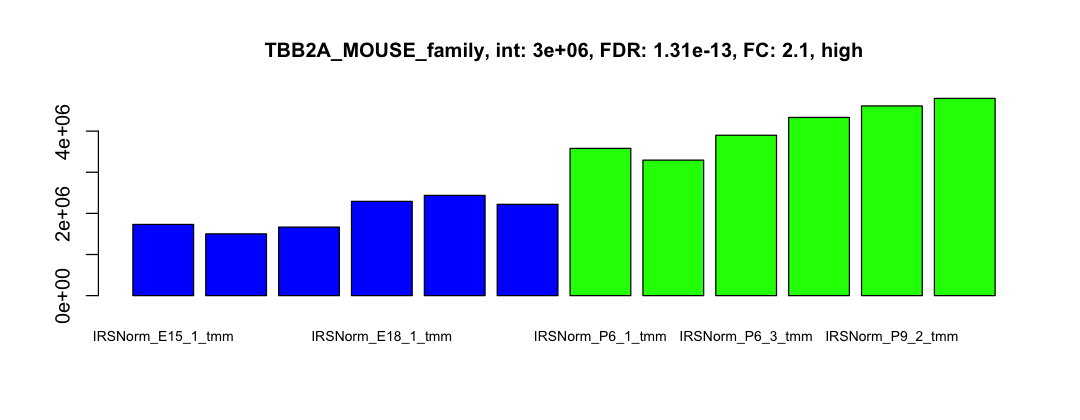

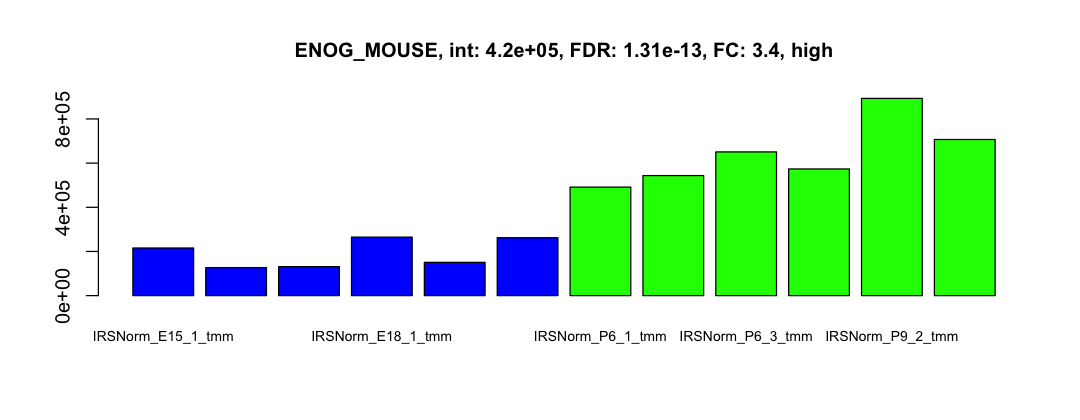

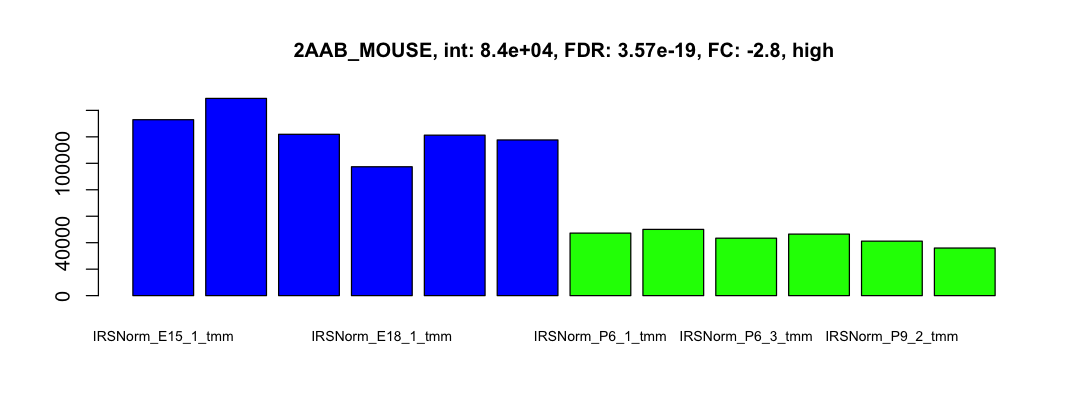

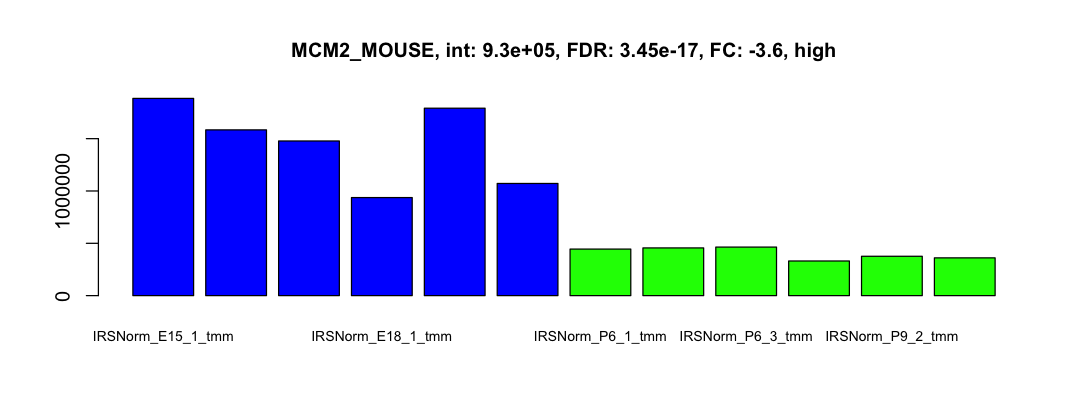

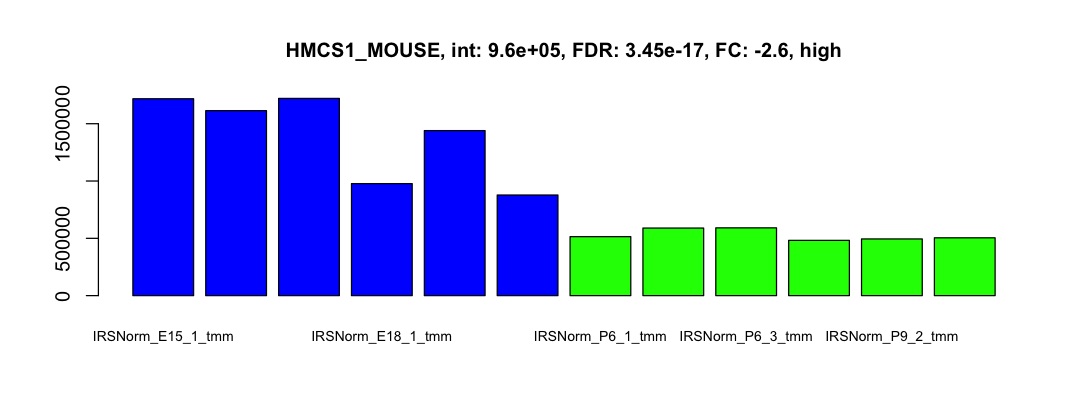

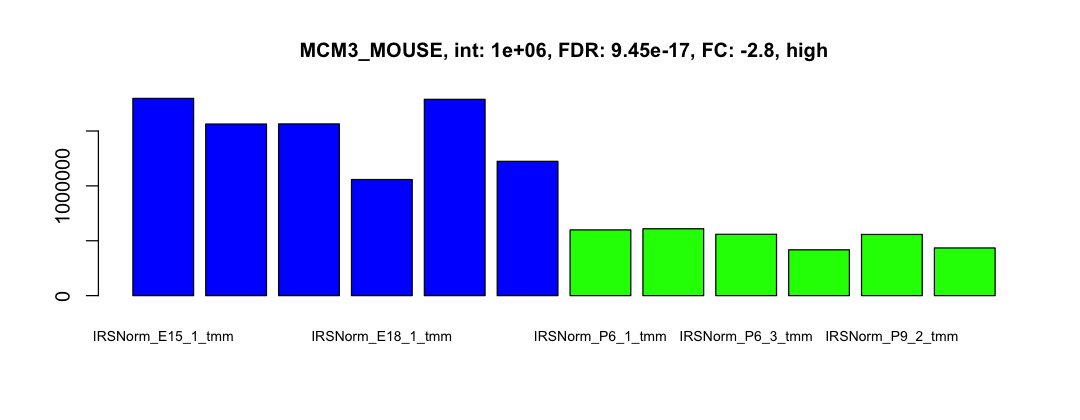

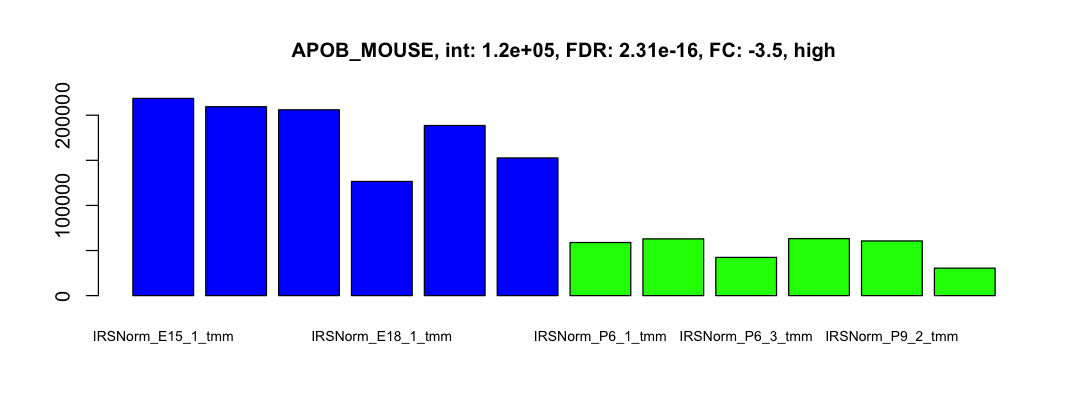

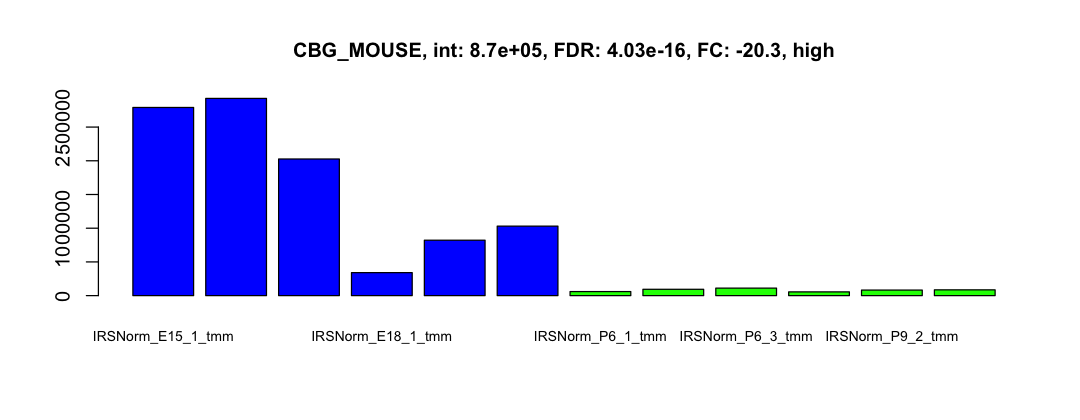

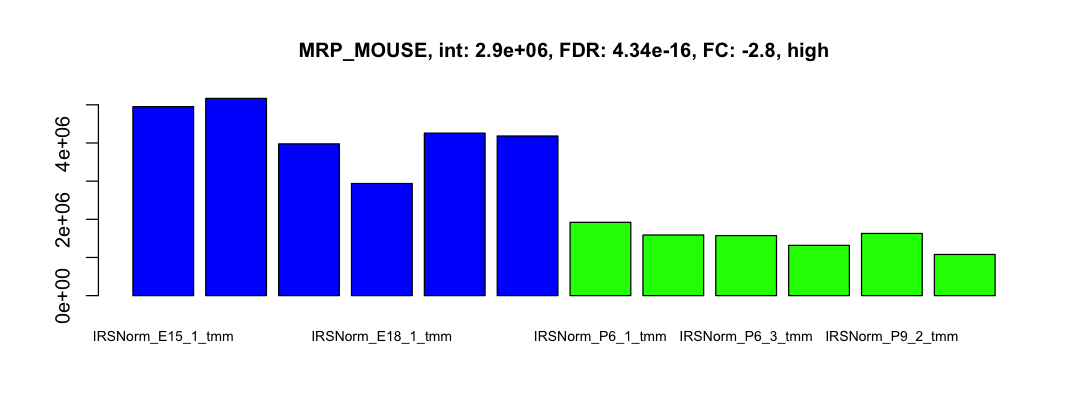

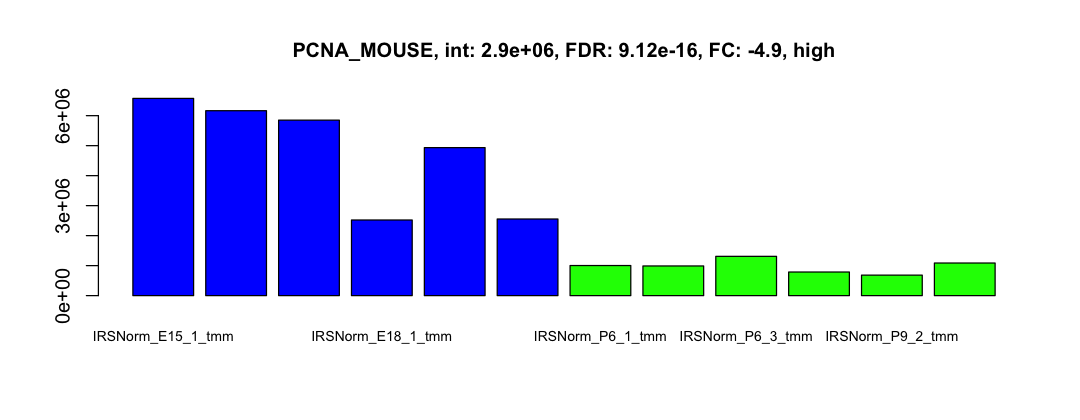

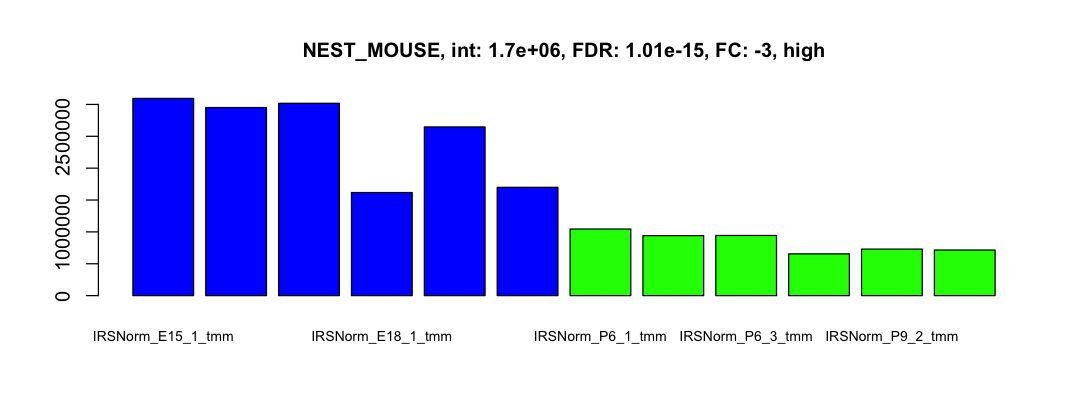

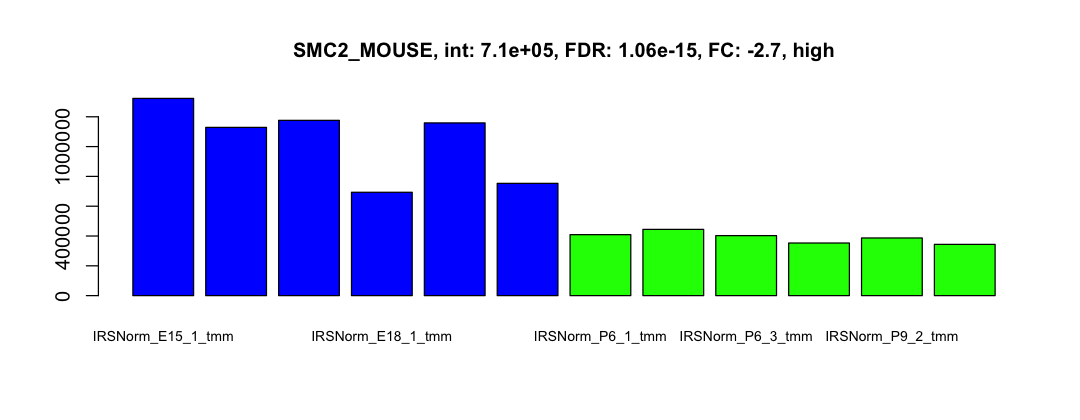

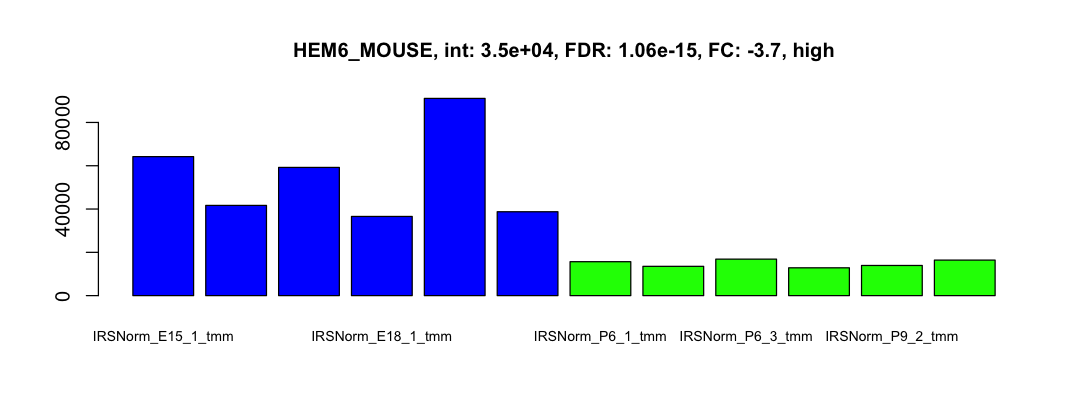

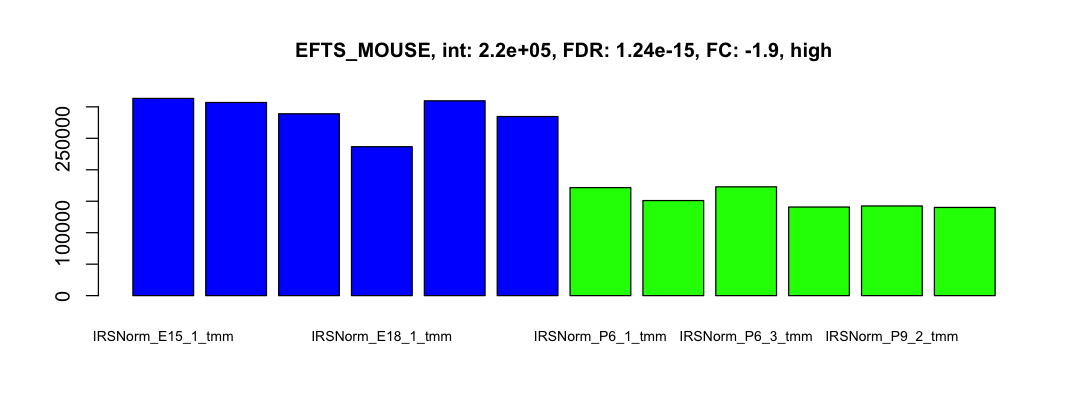

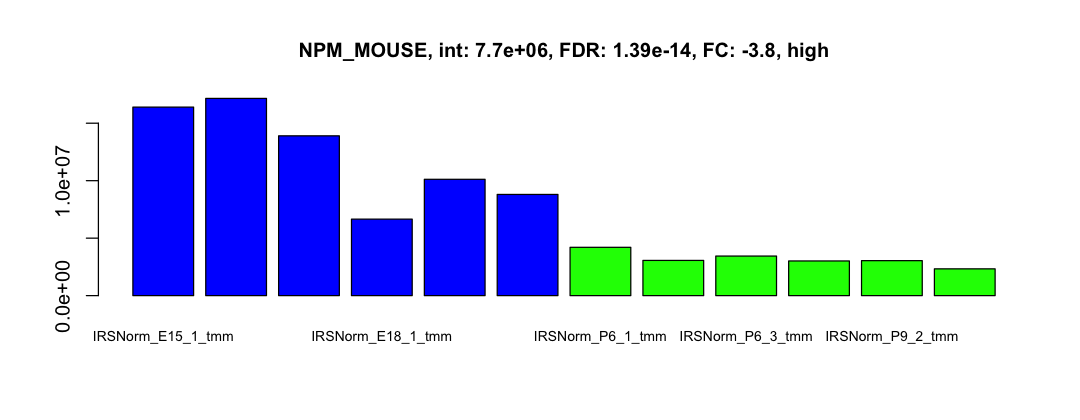

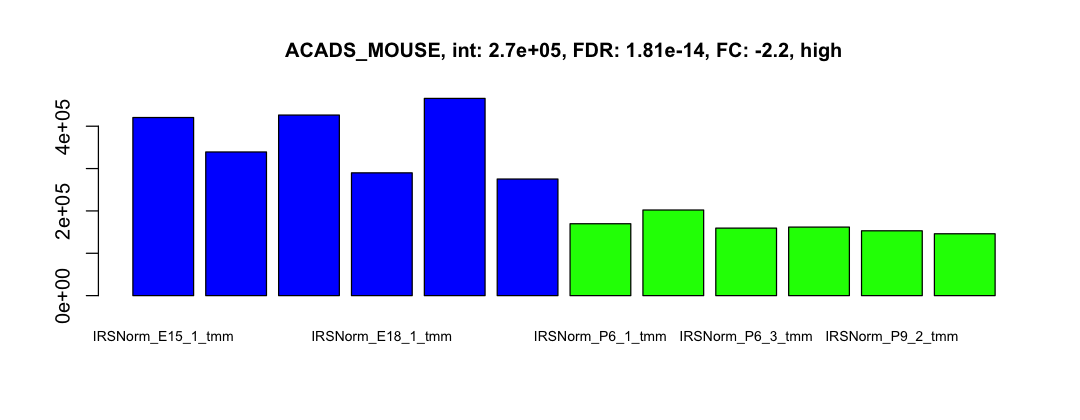

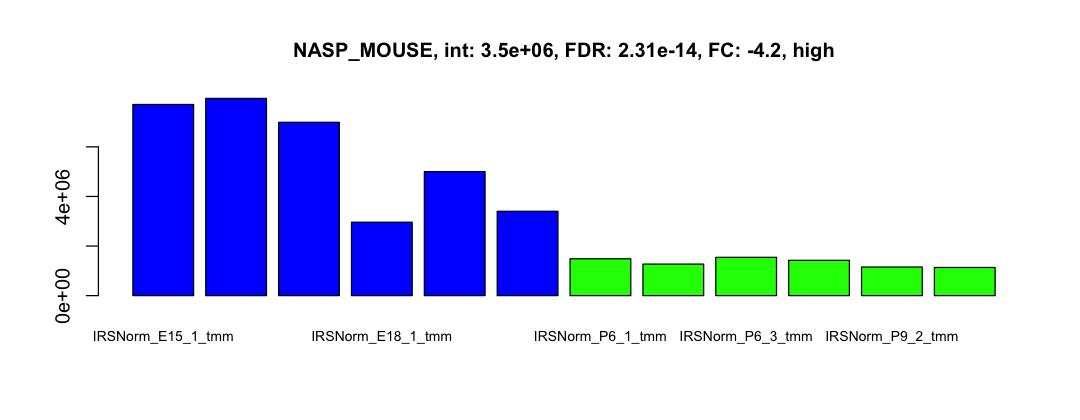

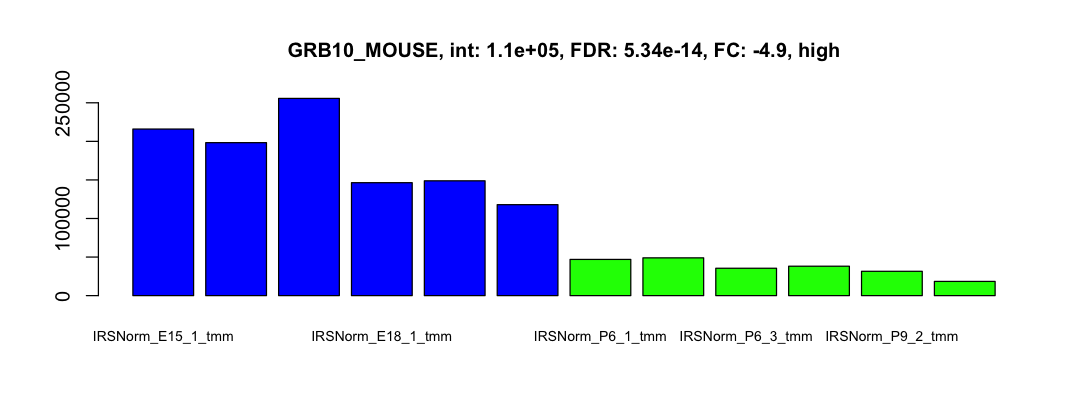

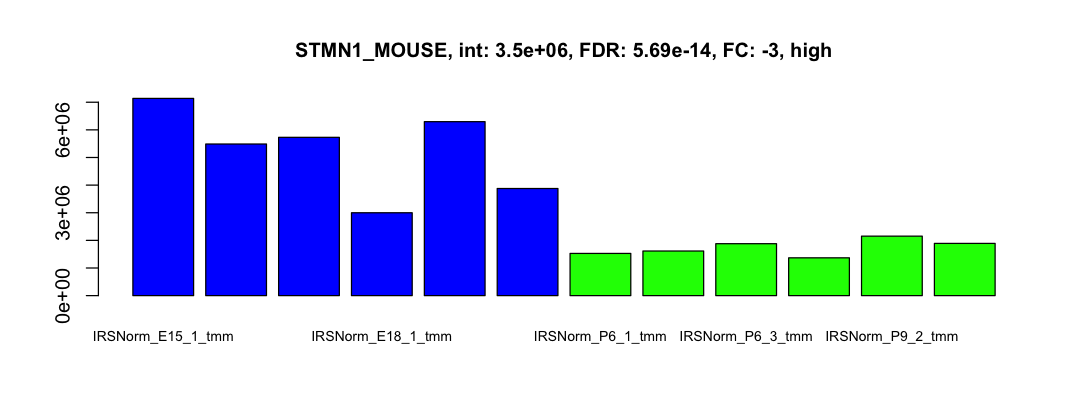

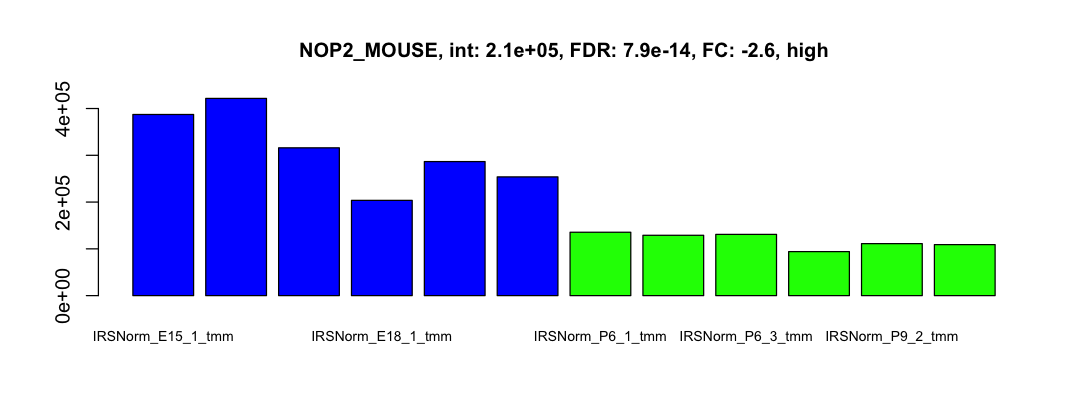

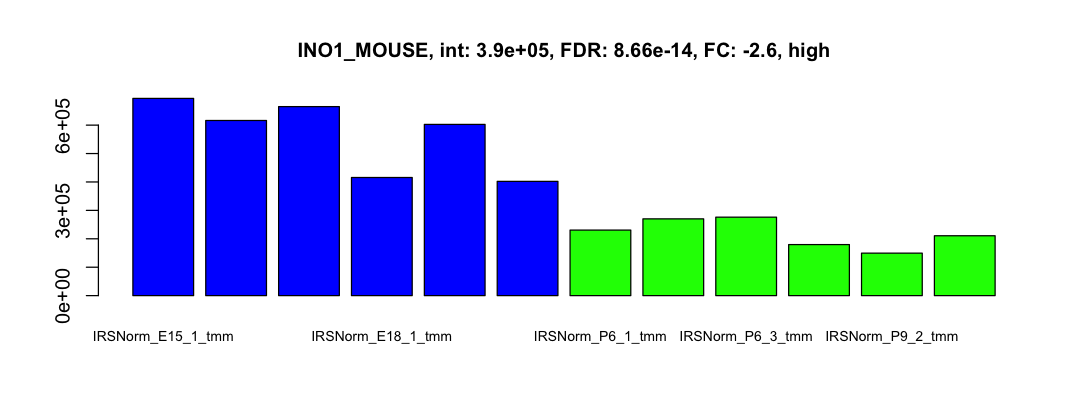

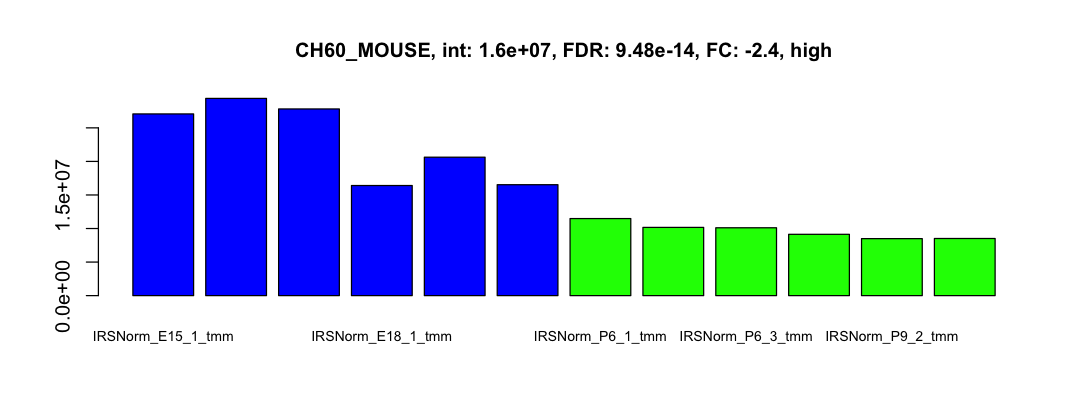

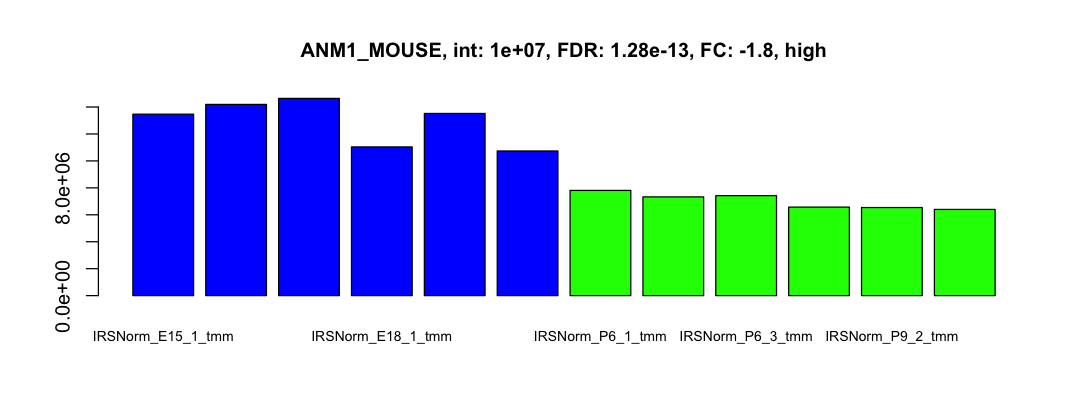

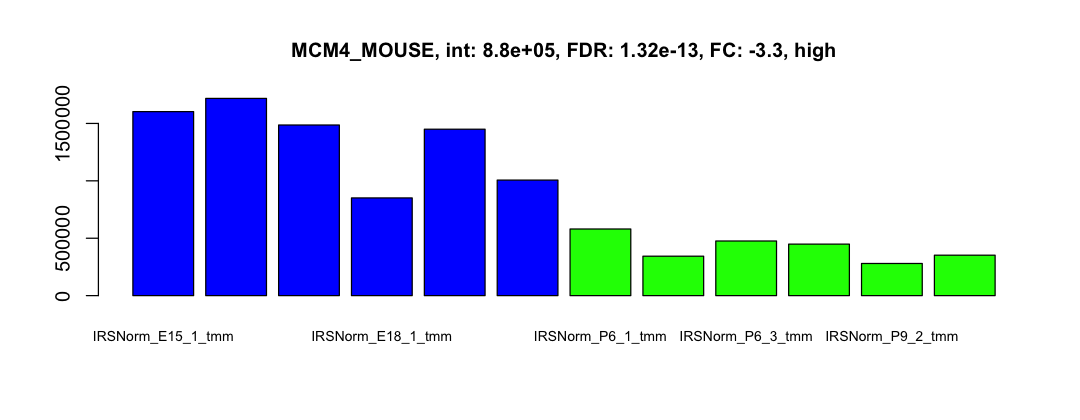

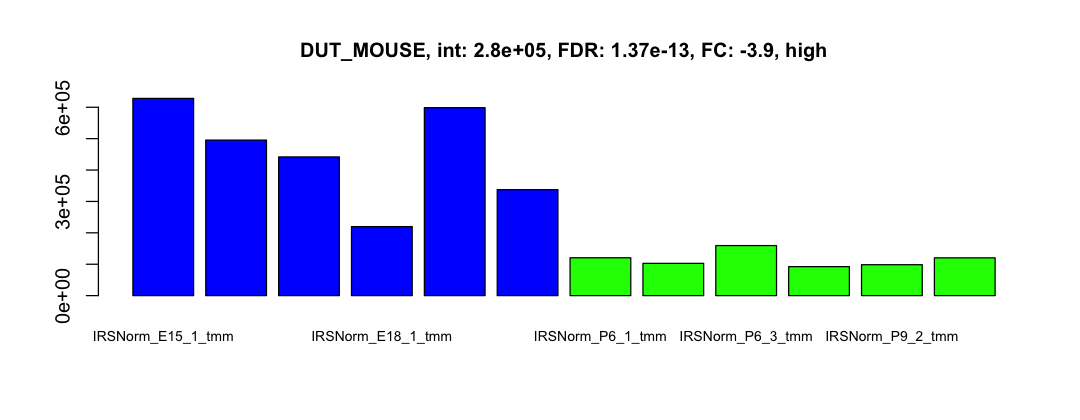

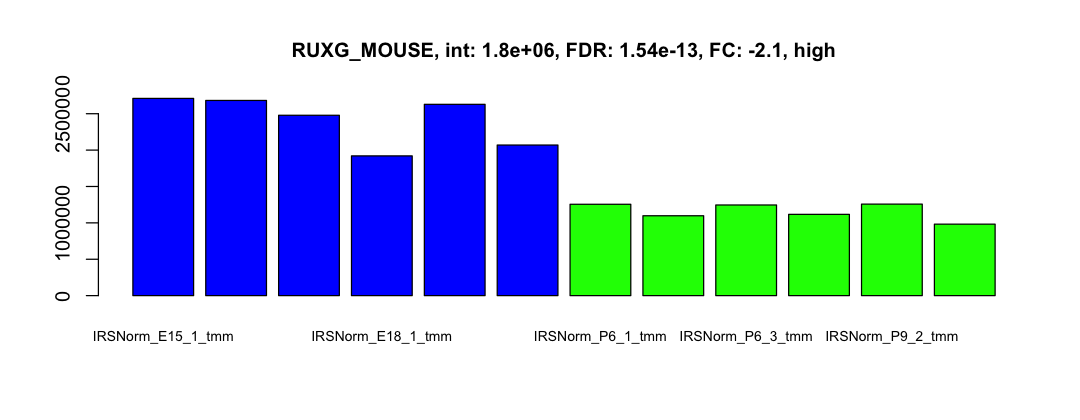

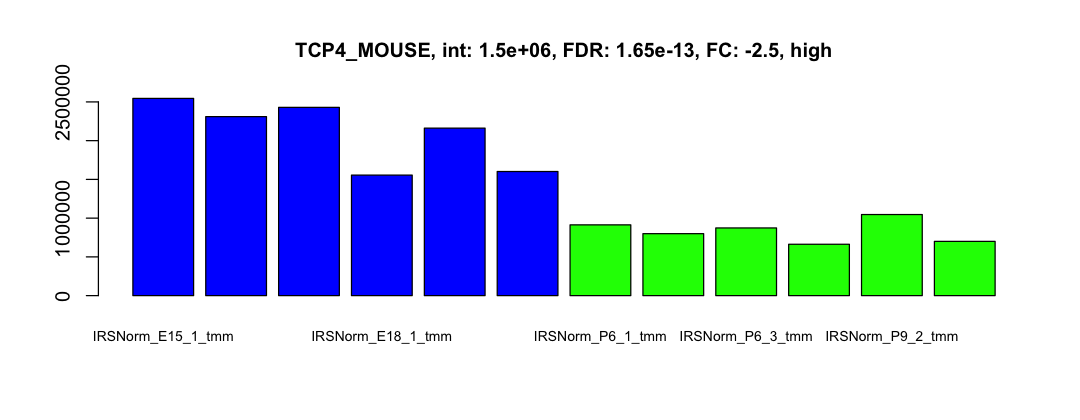

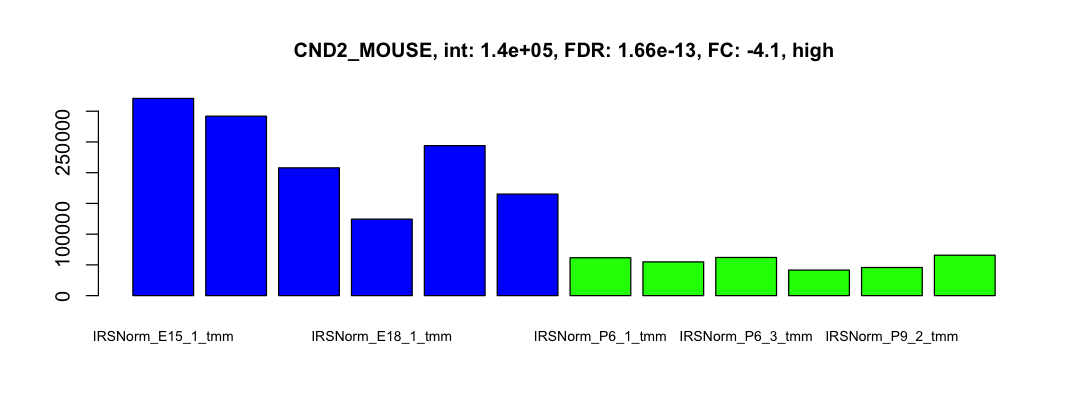

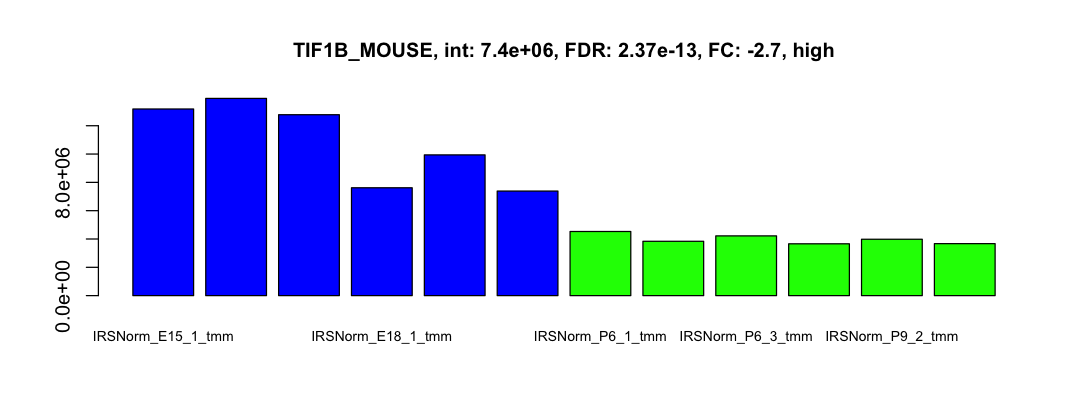

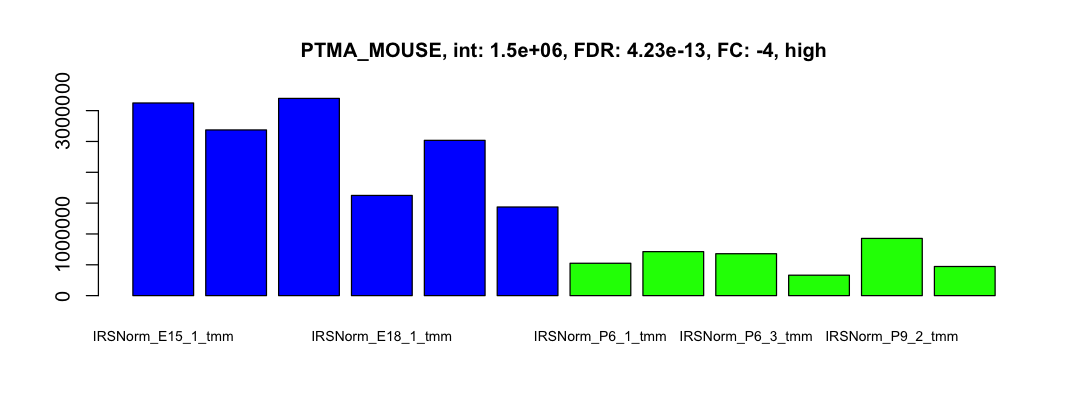

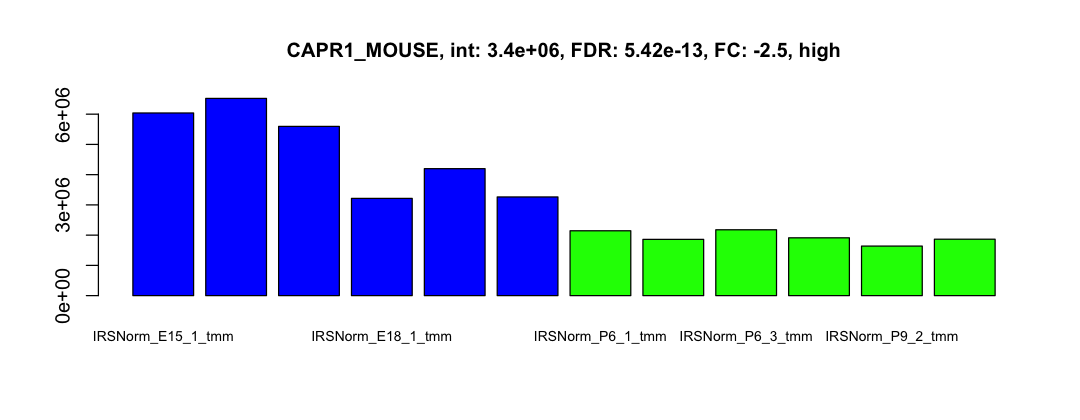

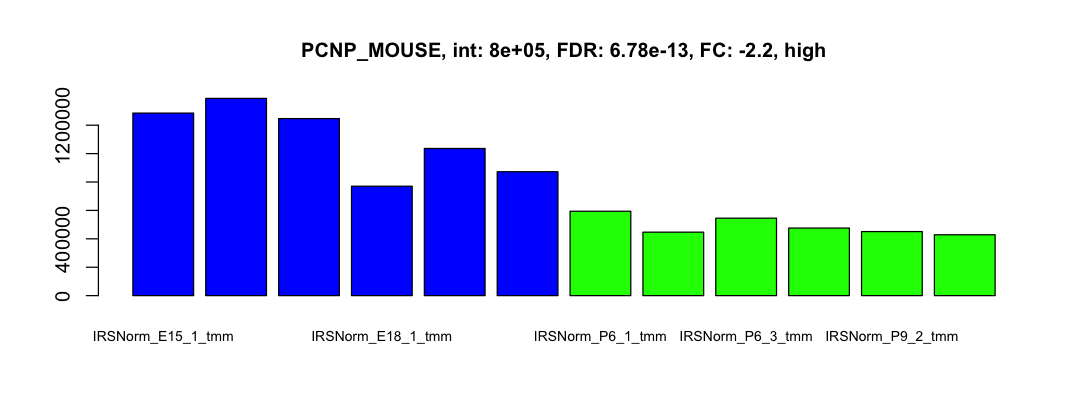

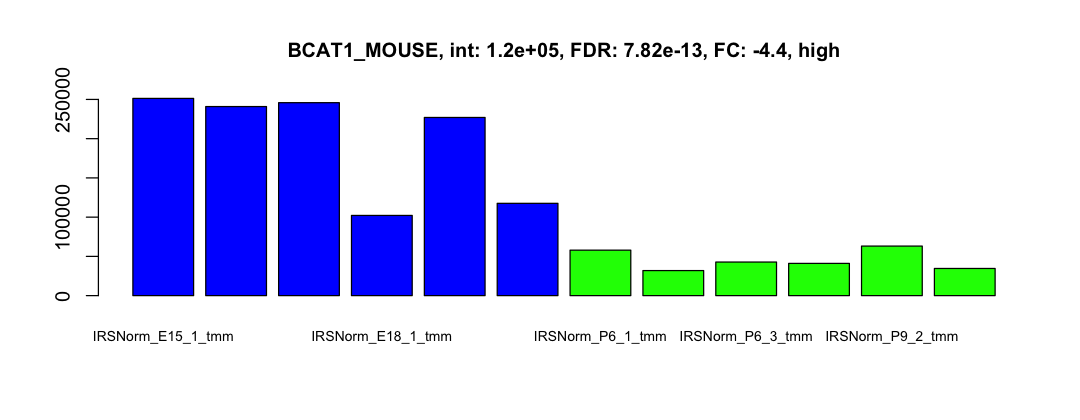

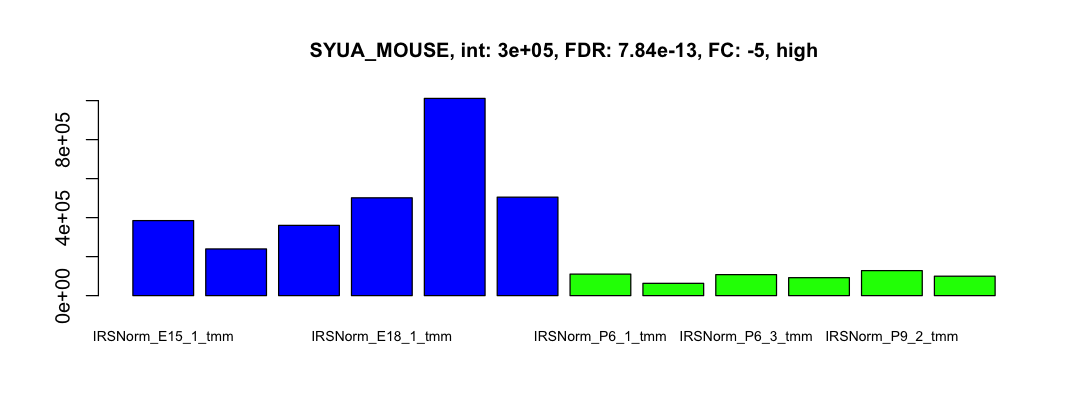

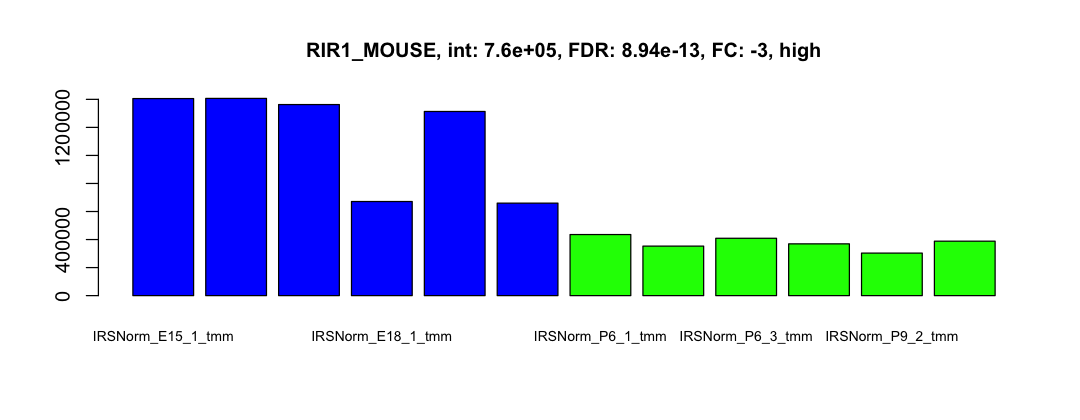

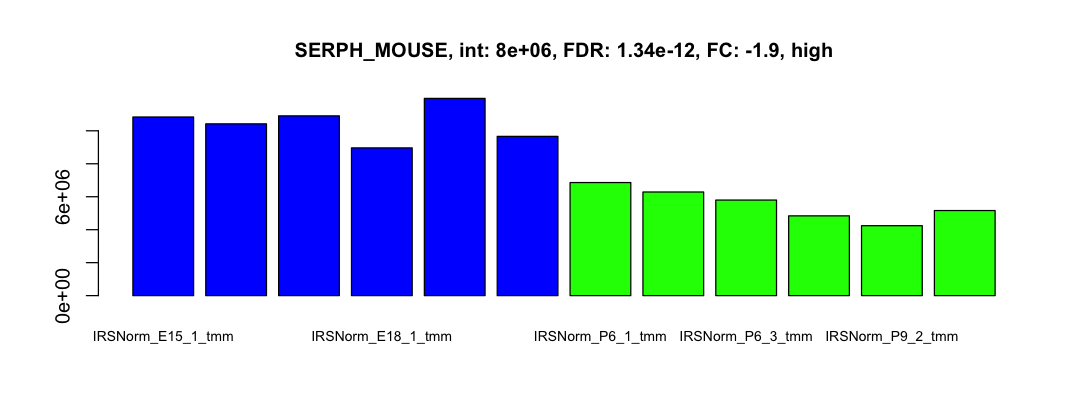

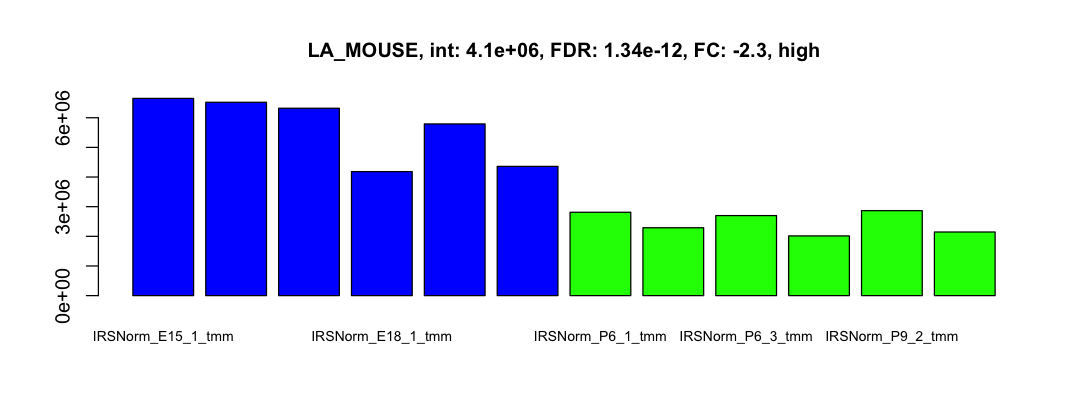

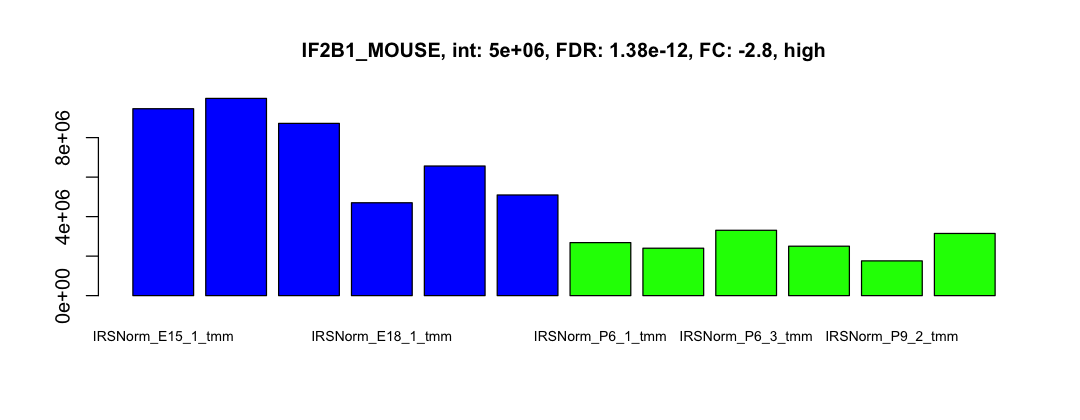

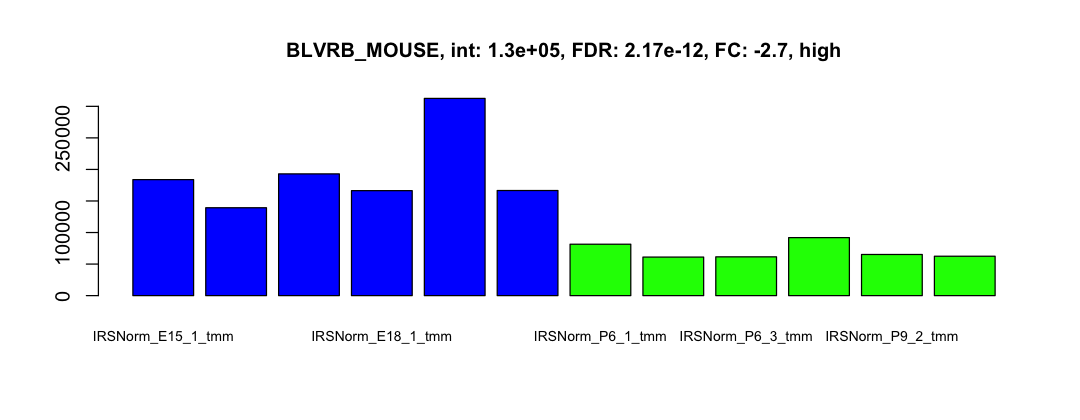

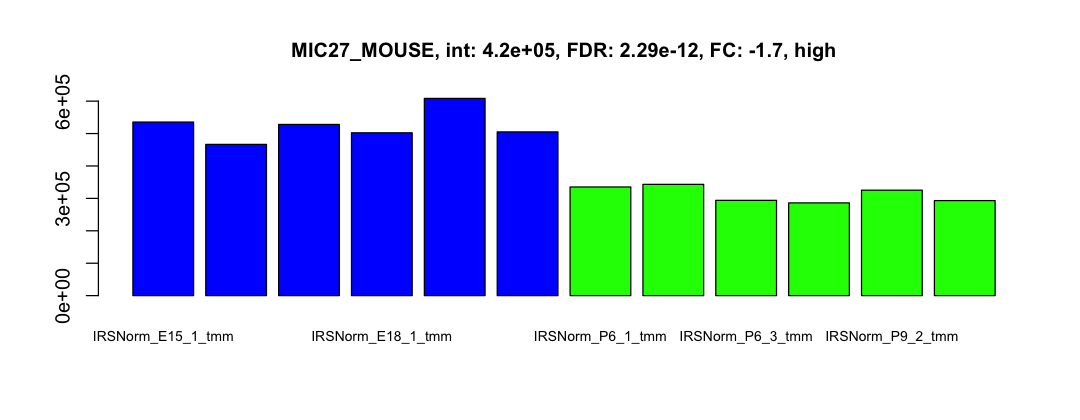

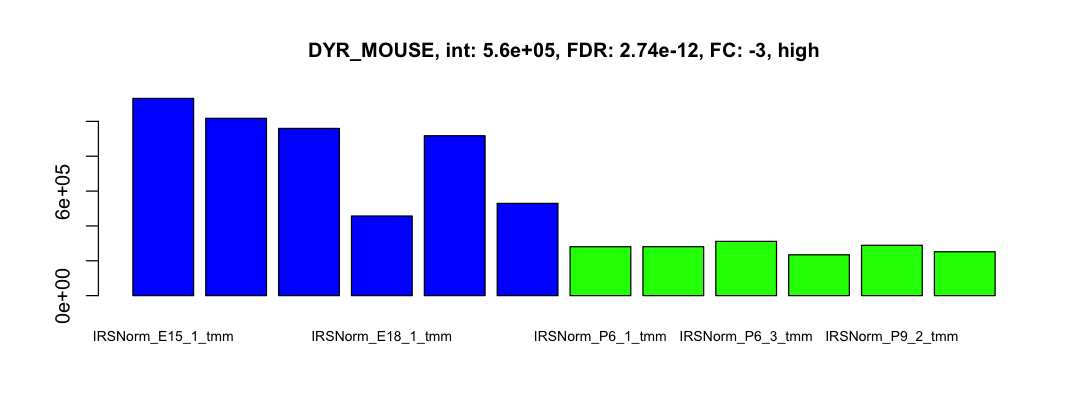

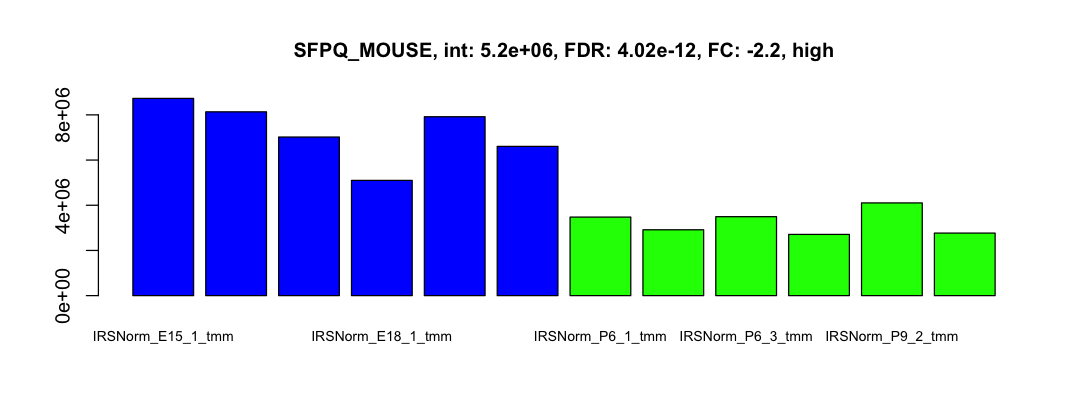

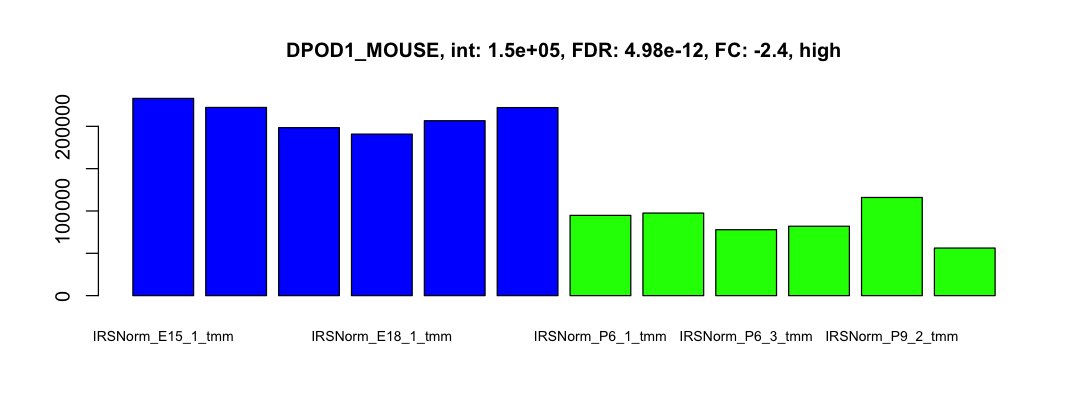

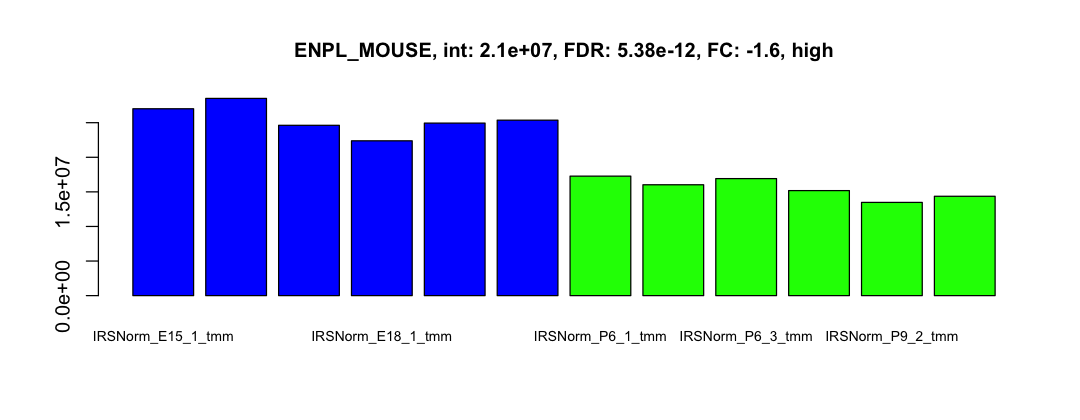

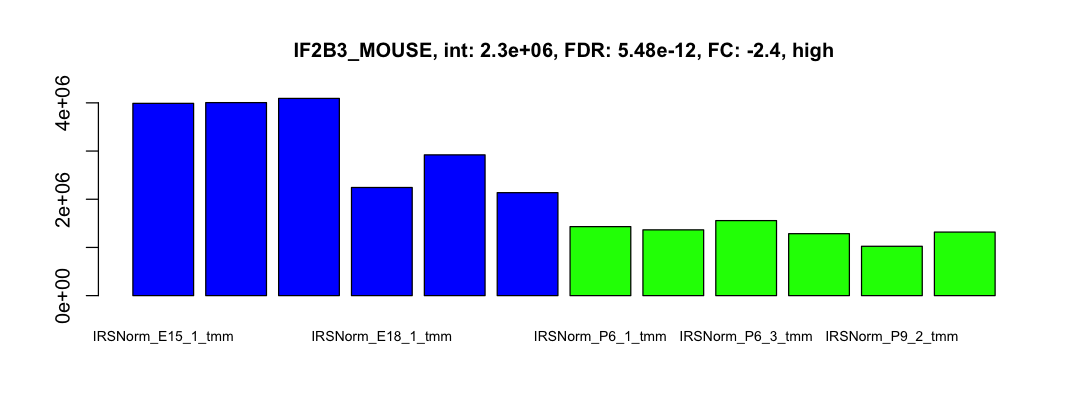

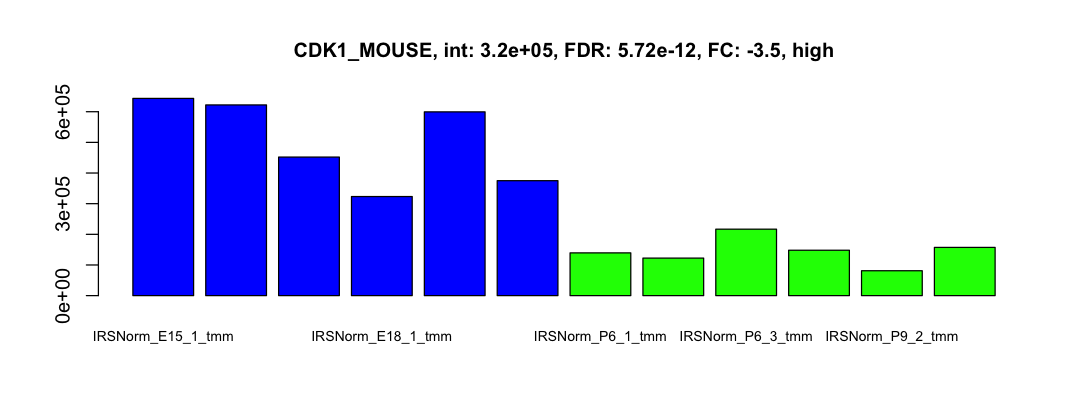

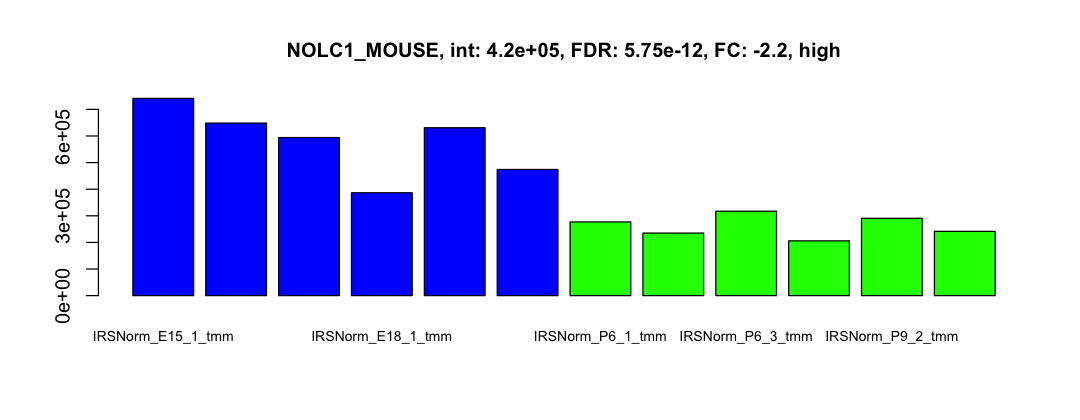

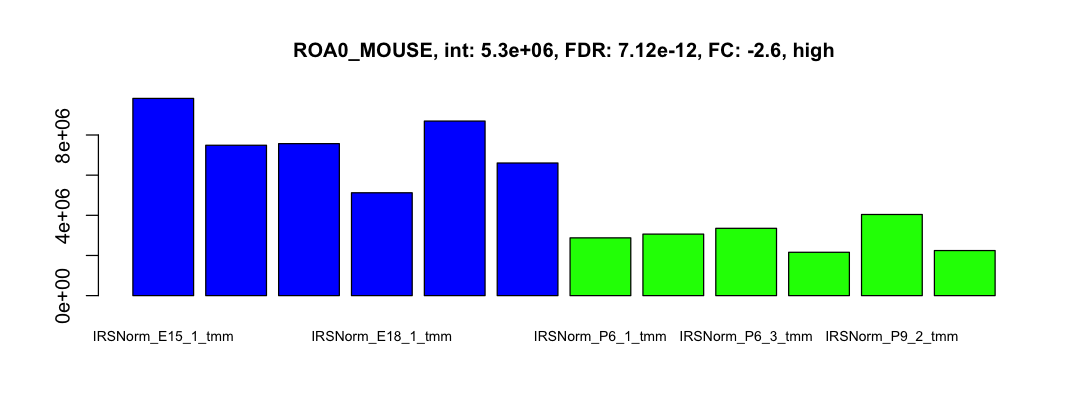

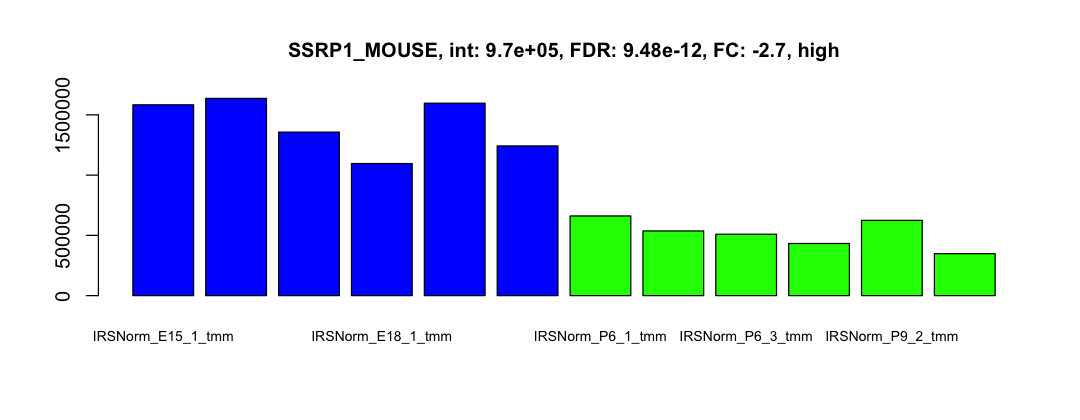

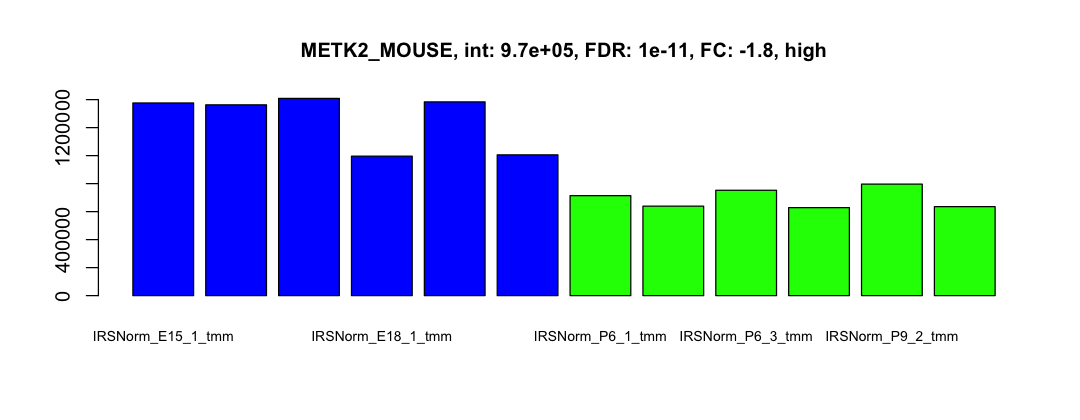

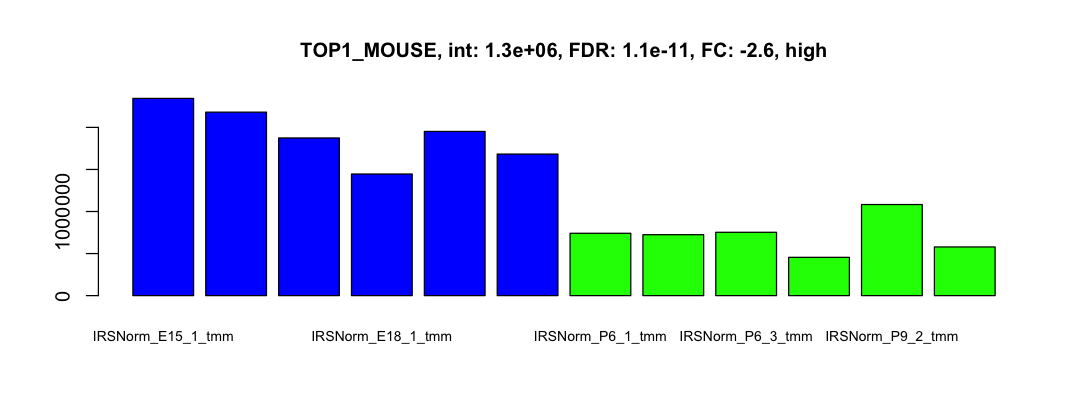

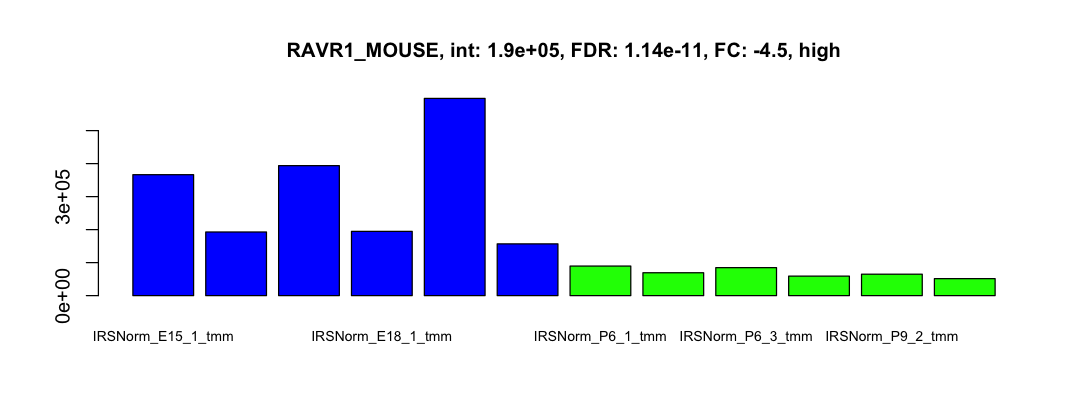

In [28]:
# look at the top candidates
set_plot_dimensions(9, 3.5)

n_left <- 6
n_right <- 6
top_tags <- 50
color <- c("blue", "green") 

plot_top_tags(results, n_left, n_right, top_tags, color)
set_plot_dimensions(9, 9)

### Top candidates look convincing

Lumping E15 and E18 together for younger lenses and P6 and P9 together for older lenses reduces some of the age resolution in favor of a more robust comparison (n=6 instead of n=3). This lens time course is simpler than most. We have three major cell populations: epithelial cells (monolayer on the anterior face of the lens), differentiating cortex cells (the outer layers of the lens (elongating cells with nuclei)), and the mature fiber cells (bags of crystallins and other major lens proteins). There is little protein turn over in lens and it is well known that crystallins progressively dominate the proteome as the lens matures.

## <a name="summary"></a>Summary

This simplified way to look at a time course experiment is not very elegant. It relies on an assumption that protein changes will be increasing with age, decreasing with age, or (because of how we normalized the data (IRS + TMM)) relatively flat with age. The fold-changes between younger and older lenses would probably be sufficient for categorization. The statistical testing might help with validating changes.

There will be some lens growth during the developmental ages. If we think about the lens as a sphere, epithelial cells grow like the surface area (R^2) and mature fiber cells grow like the volume (R^3). Major lens proteins should go up across the ages, epithelial cell proteins should go down. Proteins from the cortex probably go down, but none of these cell populations are homogeneous. Epithelial cells at the start of differentiation will be more typical cells. Mature fiber cells are mostly major lens proteins with regular cell machinery and structures degraded. The cortex cells span this spectrum.

## Save the `all_results` frame to TSV file

We collected the normalized data and statistical testing results and we can save that table to make a nice spreadsheet summary.

In [29]:
write.table(all_results, "Khan-2018_results_edgeR-exact_TMM.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [30]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.0.7     edgeR_3.24.3    limma_3.38.3    scales_1.1.1   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_1.0.2     purrr_0.3.4    
 [9] readr_1.3.1     tidyr_1.1.1     tibble_3.0.3    ggplot2_3.3.2  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       locfit_1.5-9.4   lubridate_1.7.9  lattice_0.20-41 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.8  reprex_0.3.0    
[13] evaluate_0